# TDEM Step off experiment

**Author:** [Lindsey Heagy](https://github.com/lheagy)

This notebook was used to produce the Figures shown in the thesis ["Electromagnetic imaging of subsurface injections"](https://github.com/lheagy/phd-thesis). 

Here, I look at the Time-domain EM response of conductive, permeable, steel cased wells. 


## Setup and Software environment

The requirements to run this example are in [requirements.txt](../requirements.txt). Uncomment the following cell if you need to install them. 

In [1]:
# !pip install -r ../requirements.txt

In [2]:
# core python
import numpy as np
import scipy.sparse as sp
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from scipy.constants import mu_0, inch, foot
from scipy.spatial import cKDTree
import os
import tarfile
import ipywidgets
import time
from string import ascii_lowercase
from matplotlib import rcParams
from matplotlib import gridspec

# SimPEG, discretize
import discretize
from discretize import utils
from SimPEG.EM import TDEM
from SimPEG import Utils, Maps
from pymatsolver import Pardiso

# casing utility code 
import casingSimulations as casingSim

%matplotlib inline

The fields file that contains all of the currents on the mesh through time is quite large (2.3 GB) and takes a while to download. To lighten this, we have provided results that have been down-sampled through time. If `use_downsampled_resuts` is True, we will use those, otherwise, we download the entire fields file. 

## model parameters

In [3]:
simDir = "TDEM_fields_response_1km"
# simDir = "TDEM_fields_response_1km_3"
# simDir = "TDEM_fields_response_1km_3_refinez"
# simDir = "TDEM_fields_response_1km_2"

In [4]:
# conductivities
sigma_air = 1e-4
sigma_back = 1e-2
sigma_casing = sigma_back
sigma_casing = 5e6

# relative permeability of the casing
mur_casing = 1.

# casing geometry
casing_diameter = 10e-2  
casing_t = 10e-3
casing_l = 1000

# cell size in the z-direction for the mesh
csz = 2.5 
# csz=1.25

Source electrode locations. The source runs along the $\theta = 90^{\circ}$ line

In [5]:
src_a = np.r_[casing_diameter / 2., np.pi/2, 0.]
src_b = np.r_[casing_l, np.pi/2, 0.]

In [6]:
model = casingSim.model.CasingInHalfspace(
    directory = simDir, 
    casing_d = casing_diameter - casing_t,  # I use diameter to the center of the casing wall
    casing_l = casing_l,
    casing_t = casing_t, 
    mur_casing = mur_casing,
    sigma_air = sigma_air,
    sigma_casing = sigma_casing,
    sigma_back = sigma_back,
    sigma_inside = sigma_back,
    src_a = src_a,
    src_b = src_b
)
model.filename = "casing.json"

Create the time-stepping for the forward simulation

In [7]:
# timeSteps = [
#     (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 20), (3e-2, 27)
# ]

timeSteps = [
    (1e-6, 20), (1e-5, 30), (3e-5, 30), (1e-4, 40), (3e-4, 30), (1e-3, 20), (1e-2, 17)
]

# timeSteps = [
#     (1e-6, 30), (3e-6, 30), (1e-5, 30), (3e-5, 40), (1e-4, 40), (3e-4, 30), (1e-3, 36) #(1e-2, 17)
# ]

model.timeSteps = timeSteps

print("The latest time is {:1.1e}s".format(model.timeSteps.sum()))
print("There are {} time-steps in the simulation, {} are unique "
      "(this controls how many matrix factorizations need to be done)".format(
          len(model.timeSteps), len(np.unique(np.diff(model.timeSteps)))
      )
)

The latest time is 2.0e-01s
There are 187 time-steps in the simulation, 7 are unique (this controls how many matrix factorizations need to be done)


Duplicate the model so that we can run a `background` model that does not include casing.

In [8]:
print(model.diffusion_distance(1))


12615.6626101008


In [9]:
model_background = model.copy()
model_background.sigma_casing = model_background.sigma_back
model_background.filename = "background.json"

model_permeable = model.copy()
model_permeable.mur_casing = 100
model_permeable.filename = "permeable.json"

In [10]:
# preserve product of conductivity and cross-sectional area for solid cylinder 
sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
print(sigmaA)

model_approx_casing = model.copy()
model_approx_casing.sigma_inside = sigmaA
model_approx_casing.sigma_casing = sigmaA
model_approx_casing.filename = "approx_casing.json"

# treat it as solid steel 
# sigmaA = model.sigma_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
# print(sigmaA)

# model_approx_casing2 = model.copy()
# model_approx_casing2.sigma_inside = model.sigma_casing
# model_approx_casing2.sigma_casing = model.sigma_casing
# model_approx_casing2.filename = "approx_casing2.json"


# preserve product of permeability and thickness
muT = (model_permeable.mur_casing * model.casing_t + 1*model.casing_a)/ model.casing_b
print(muT)

model_approx_permeable = model_approx_casing.copy()
model_approx_permeable.mur_inside = muT
model_approx_permeable.mur_casing = muT
model_approx_permeable.filename = "approx_permeable.json"

# muT2 = model_permeable.mur_casing * (model.casing_b**2 - model.casing_a**2)/model.casing_b**2
# print(muT2)

# model_approx_permeable2 = model_approx_casing.copy()
# model_approx_permeable2.mur_inside = muT2
# model_approx_permeable2.mur_casing = muT2
# model_approx_permeable2.filename = "approx_permeable2.json"

1799999.9999999993
20.8


keep track of the models in a dictionary

In [11]:
# model_names = ["casing",  "approx_casing", "permeable", "approx_permeable", "background"] #, #, "approx_casing2"] #,  "permeable", "approx_permeable", "approx_permeable2"]
# model_names = ["casing", "permeable", "approx_casing", "approx_permeable","background"] #, #, "approx_casing2"] #,  "permeable", "approx_permeable", "approx_permeable2"]
model_names = ["casing", "background" , "permeable"] #, "approx_casing", "approx_permeable"]
models = [model, model_background, model_permeable, model_approx_casing, model_approx_permeable]
model_dict = dict(zip(
    model_names, 
    models #, model_background], #, model_approx_permeable2]
))

## Mesh

We set up a 3D cylindrical mesh for the simulations. Both the casing and background models will be run on the same mesh. 

In [12]:
model.diffusion_distance()

5701.1071274119095

In [13]:
# Theta discretization
hy = np.ones(12)
hy = hy*2*np.pi / hy.sum()

In [14]:
meshGen = casingSim.mesh.CasingMeshGenerator(
    directory = simDir, 
    modelParameters = model, 
    csx1 = model.casing_t/4,
    csx2 = 100,
    domain_x = casing_l,  # use 2.5m cells out to 300m. 
    hy = hy,
    npadx = 8, # 6
    npadz = 17,  #14
#     npadx = 10, 
#     npadz = 19,
    csz = csz,
)

In [15]:
mesh = meshGen.mesh

In [16]:
print("The mesh has {} cells".format(meshGen.mesh.nC))

The mesh has 426240 cells


plot the mesh

/anaconda3/lib/python3.6/site-packages/matplotlib/projections/polar.py:63: RuntimeWarning: invalid value encountered in less
  mask = r < 0


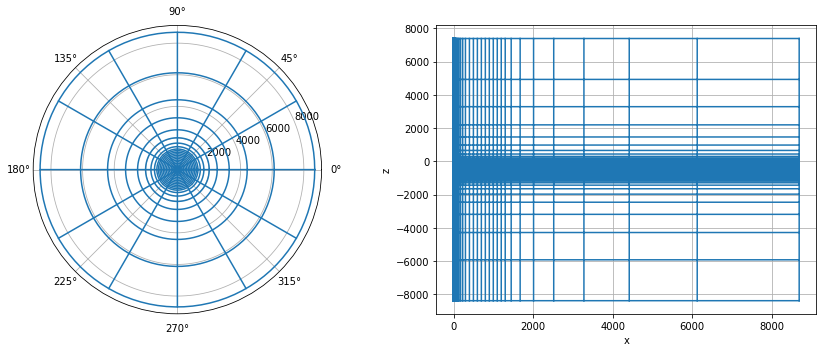

In [17]:
ax = meshGen.mesh.plotGrid()
# ax[0].set_rlim([50., 100.])
# ax[1].set_ylim([])

## Physical Properties

Now that we have a mesh and a model defined, we populate the mesh with physical properties

In [18]:
physprops_dict = {
    key: casingSim.model.PhysicalProperties(
        modelParameters=m, meshGenerator=meshGen
    )
    for key, m in model_dict.items() 
}


In [19]:
pp =physprops_dict["casing"]

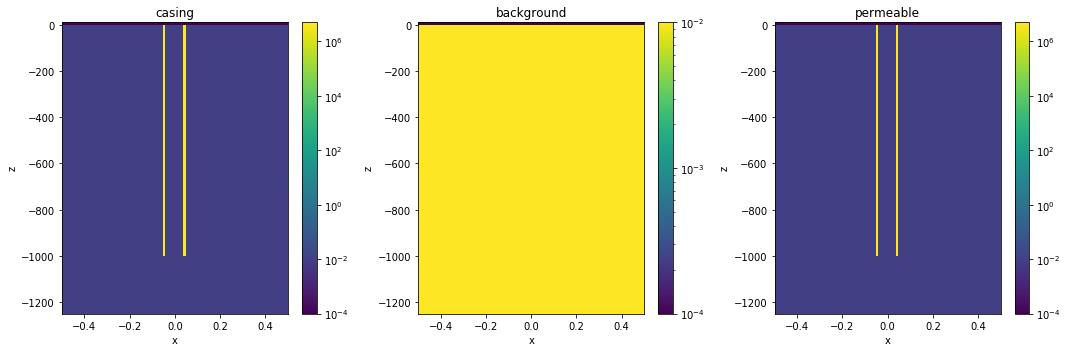

In [20]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_sigma(ax=a, pcolorOpts={'norm':LogNorm()})
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

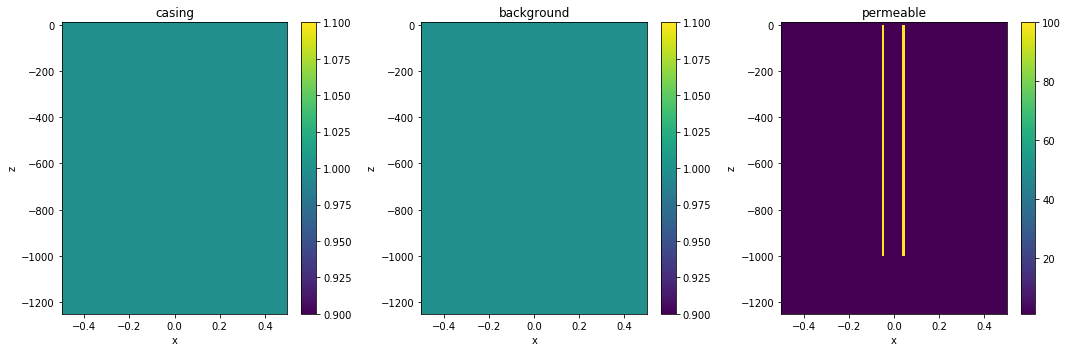

In [21]:
fig, ax = plt.subplots(1, len(model_names), figsize=(5*len(model_names), 5))

xlim = 0.5*np.r_[-1., 1.]
ylim = np.r_[-1.25*casing_l, 10.]

for m, a in zip(model_names, ax):
    physprops_dict[m].plot_mur(ax=a)
    a.set_xlim(xlim)
    a.set_ylim(ylim) 
    a.set_title(m)

plt.tight_layout()

## Survey

The source is a grounded source with one electrode at 1000m and the other electrode connected to the top of the casing. A wire connects them. Note that we will use H-J formulation t solve this problem, so the source is defined as current that goes through the faces of the mesh. 

In [22]:
src_theta = np.pi/2. + mesh.hy[0]/2.
model.src_a[1] = src_theta
model.src_b[1] = src_theta

In [23]:
top_src_a = model.src_a.copy()
top_src_a[2] = -mesh.hz.min()/2.

In [24]:
downhole_src_a = model.src_a.copy()
downhole_src_a[0] = 0.
downhole_src_a[2] = -950.

In [25]:
src_top = casingSim.sources.TopCasingSrc(
    directory=simDir, 
    modelParameters=model, 
    meshGenerator=meshGen,
    src_a=top_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="top_casing",
)

src_downhole = casingSim.sources.DownHoleCasingSrc(
    directory=simDir, 
    modelParameters=model,
    meshGenerator=meshGen,
    src_a=downhole_src_a,
    src_b=model.src_b,
    physics="TDEM",
    filename="downhole",
)

sources = [src_top, src_downhole]
srcList = src_top.srcList + src_downhole.srcList

In [26]:
casingSimSrcList = casingSim.sources.SourceList(
    filename="sources.json",
    directory=simDir,
    sources = sources  
)

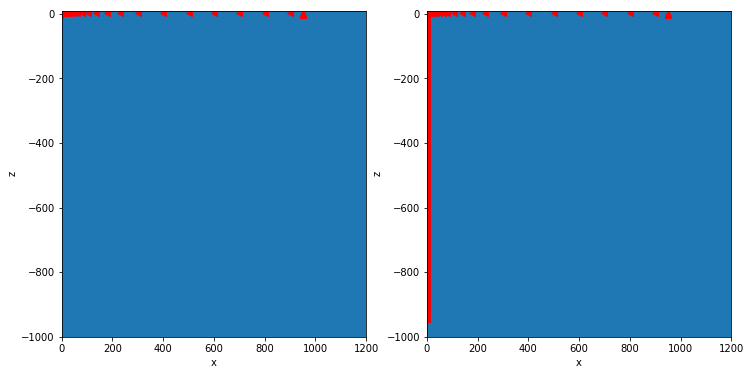

In [27]:
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for a, src in zip(ax, sources): 
    meshGen.mesh.plotGrid(slice='theta', ax=a)
    src.plot(ax=a)

    a.set_xlim([0., 1200])
    a.set_ylim([-1000., 10.])

## Simulation

In [28]:
save_files = False

In [29]:
model_dict

{'casing': <casingSimulations.model.CasingInHalfspace at 0x103c969b0>,
 'background': <casingSimulations.model.CasingInHalfspace at 0x103d44be0>,
 'permeable': <casingSimulations.model.CasingInHalfspace at 0x103d44c18>}

In [30]:
sim = casingSim.run.SimulationTDEM(
    directory=simDir, 
    formulation='j',
    meshGenerator=meshGen,
    modelParameters=model,
    srcList=casingSimSrcList, 
)

# sim.save()

In [31]:
if save_files:
    for key in model_names:
        model_dict[key].save()
    casingSimSrcList.save()
    meshGen.save()

In [32]:
m = "casing"
sim = casingSim.run.SimulationTDEM(
        modelParameters= simDir + "/" + m + ".json",
        meshGenerator=simDir + "/" +'MeshParameters.json',
        srcList=simDir + "/" +'sources.json',
        fields_filename=simDir + "/" +m + "_fields.npy"
    )

## load pre-computed results

In [33]:
# if use_downsampled_results:
#     f = "TDEM_fields_downsampled"
# else:
f = "TDEM_fields_response_1km"
    
# if not os.path.isdir(f):
#     download = Utils.download(
#         "https://storage.googleapis.com/simpeg/heagy_2018_emcyl/{}.tar.gz".format(f)
#     )  
#     tar = tarfile.open(download, "r:*")
#     tar.extractall()
#     tar.close()

load the results into memory

re-populate the fields object (this takes a couple minutes)

In [34]:
# model_names = model_names[:4]
# model_names += ["approx_permeable2"]

# model_names = ["casing", "permeable"] + model_names[3:]
# model_names += ["approx_permeable2"]
print(model_names)

['casing', 'background', 'permeable']


In [35]:
%%time

# if rerun is False: 
    # recreate the fields object
fields_dict = {}

for key in model_names:
    
    if key not in fields_dict.keys():
#     t = time.time()
        print("loading {}".format(key))
        sol = np.load(f + os.path.sep + "{}_fields.npy".format(key))
        sim.prob.model = physprops_dict[key].model
        fields_dict[key] = sim.prob.fieldsPair(sim.meshGenerator.mesh, sim.survey)
        print("   populating fields")
        fields_dict[key][:, 'jSolution', :] = sol
#     print("... done. time: {:1.2f}s".format(time.time() - t))

loading casing
   populating fields
loading background
   populating fields
loading permeable
   populating fields
CPU times: user 2min 48s, sys: 35.4 s, total: 3min 23s
Wall time: 3min 58s


In [36]:
sim_dict = {}
for key in model_names:
#     s = sim.copy()
#     s.modelParameters = model_dict[key]
#     s.
    sim_dict[key] = sim.copy()
    sim_dict[key].modelParameters = model_dict[key]
    sim_dict[key].srcList = sim.srcList

In [37]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [38]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":0.15,
        "theta_ind":3, 
        "view":"j"
    }
)

interactive(children=(FloatText(value=0.15, description='max_r'), FloatText(value=-10.0, description='min_dept…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [39]:
from matplotlib import rcParams
rcParams['font.size'] = 14

In [40]:
viewer.primary = "casing"

In [41]:
viewer.widget_cross_section(
    defaults={
        "max_depth":1.5*model.casing_l,
        "min_depth":-10,
        "max_r":1.5*model.casing_l,
        "theta_ind":3,
        "view":"j"
    }, 
    figwidth=12
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=-10.0, description='min_de…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

## Plan View 

In [42]:
viewer = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [43]:
viewer.widget_depth_slice(
    fixed={"rotate": True, "figwidth":6}, 
    defaults={
        "max_r":1500, "z_ind":400, "time_ind":1, "view":"j", "model_key":"casing", 
        "use_aspect":True, "theta_shift":mesh.hy[0]/2, "k":10
    }
)

interactive(children=(FloatText(value=1500.0, description='max_r'), FloatText(value=0.0, description='clim_min…

<function ipywidgets.widgets.interaction._InteractFactory.__call__.<locals>.<lambda>(*args, **kwargs)>

In [44]:
mesh.gridFx[mesh.gridFx[:, 2] == -csz/2., :]

array([[ 2.50000000e-03,  2.61799388e-01, -1.25000000e+00],
       [ 5.00000000e-03,  2.61799388e-01, -1.25000000e+00],
       [ 7.50000000e-03,  2.61799388e-01, -1.25000000e+00],
       ...,
       [ 4.41718750e+03,  6.02138592e+00, -1.25000000e+00],
       [ 6.12578125e+03,  6.02138592e+00, -1.25000000e+00],
       [ 8.68867188e+03,  6.02138592e+00, -1.25000000e+00]])

In [45]:
# @dask.delayed
def get_e_data(key, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
    f = fields_dict[key]
    
    data = []
    
    for src_ind in range(len(f.survey.srcList)):
        e = f[f.survey.srcList[src_ind], 'e', :]
        print('   fetched e')
        er = e[:mesh.vnF[0], :]
        del e

        e_tz_inds = (
            (mesh.gridFx[:, 0]>=xmin) & (mesh.gridFx[:, 0]<=xmax) & 
            (mesh.gridFx[:, 1] == mesh.vectorCCy[0]) & 
            (mesh.gridFx[:, 2] == -csz/2.)
        )

        x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
        rx_x = mesh.vectorNx[x_inds]

        time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
        times = f.survey.prob.timeMesh.gridN[time_inds]

        e_data = (er[e_tz_inds, :])[:, time_inds]
        del er

        e_data = e_data.reshape(len(rx_x), len(times), order="F")
        data += [e_data]
    
    return rx_x, times, data

In [46]:
# @dask.delayed
def get_dbdt_data(key, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
    f = fields_dict[key]
    
    data = []
    
    for src_ind in range(len(f.survey.srcList)):
        dbdt = f[f.survey.srcList[src_ind], 'dbdt', :]
        print('   fetched dbdt')
        dbdt = dbdt[mesh.vnE[0]:mesh.vnE[:2].sum(), :]

        dbdt_tz_inds = (
            (mesh.gridEy[:, 0]>=xmin) & (mesh.gridEy[:, 0]<=xmax) & 
            (mesh.gridEy[:, 1] == mesh.vectorCCy[0]) & 
            (mesh.gridEy[:, 2] == 0)
        )

        x_inds = (mesh.vectorNx>=xmin) & (mesh.vectorNx<=xmax)
        rx_x = mesh.vectorNx[x_inds]

        time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
        times = f.survey.prob.timeMesh.gridN[time_inds]

        dbdt_data = (dbdt[dbdt_tz_inds, :])[:, time_inds]
        del dbdt

        dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
        data += [dbdt_data]
    
    return rx_x, times, data

In [47]:
# # @dask.delayed
# def get_dbzdt_data(key, src_ind=0, xmin=5, xmax=1000, rx_times=np.logspace(-5, np.log10(5e-3), 20)):
#     f = fields_dict[key]
#     dbdt = f[f.survey.srcList[src_ind], 'dbdt', :]
#     print('   fetched dbzdt')
#     dbdt = dbdt[mesh.vnE[:2].sum():, :]
    
#     dbdt_tz_inds = (
#         (mesh.gridEz[:, 0] >= xmin) & (mesh.gridEz[:, 0] <= xmax) & 
#         (mesh.gridEz[:, 1] == mesh.vectorNy[0]) & 
#         (mesh.gridEz[:, 2] == -csz/2)
#     )

#     x_inds = (mesh.vectorNx >= xmin) & (mesh.vectorNx <= xmax)
#     rx_x = mesh.vectorNx[x_inds]
    
#     time_inds = discretize.utils.closestPoints(f.survey.prob.timeMesh, rx_times, 'N')
#     times = f.survey.prob.timeMesh.gridN[time_inds]
#     del f
    
#     dbdt_data = (dbdt[dbdt_tz_inds, :])[:, time_inds]
#     del dbdt
    
#     dbdt_data = dbdt_data.reshape(len(rx_x), len(times), order="F")
    
#     return rx_x, times, dbdt_data

In [48]:
data_time = {}

for key in model_names:
    if key not in data_time.keys():
        x, t, data_time[key] = get_e_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN)

   fetched e
   fetched e
   fetched e
   fetched e
   fetched e
   fetched e


In [49]:
dbdt_time = {}

for key in model_names:
    if key not in dbdt_time.keys():
        x, t, dbdt_time[key] = get_dbdt_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN)

   fetched dbdt
   fetched dbdt
   fetched dbdt
   fetched dbdt
   fetched dbdt
   fetched dbdt


In [50]:
# dbzdt_time = {}

# for key in model_names:
#     if key not in dbzdt_time.keys():
#         xz, tz, dbzdt_time[key] = get_dbzdt_data(key, rx_times=fields_dict[key].survey.prob.timeMesh.gridN, src_ind=0)

In [51]:
from matplotlib import colors
from matplotlib import cm as cmap

In [52]:
fields_dict["casing"].survey.prob.timeMesh.gridN[-1]

0.20422000000000004

In [53]:
rx_times = np.logspace(np.log10(1e-5), np.log10(0.05), 10)
# rx_times = rx_times - rx_times[0] + fields_dict["casing"].survey.prob.timeMesh.gridN[1]
time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, rx_times, 'N')
times = fields_dict["casing"].survey.prob.timeMesh.gridN[time_inds]
print(times)

[1.000e-05 3.000e-05 7.000e-05 1.700e-04 4.400e-04 1.130e-03 2.920e-03
 7.620e-03 1.922e-02 5.422e-02]


In [54]:
cm = plt.get_cmap('magma')
key = "casing"
c_norm = colors.LogNorm(vmin=times.min(), vmax=times.max()*6)
scalar_map = cmap.ScalarMappable(norm=c_norm, cmap=cm)
scalar_map.set_array([])

c_norm_msec = colors.LogNorm(vmin=times.min()*1e3, vmax=times.max()*6*1e3)
scalar_map_msec = cmap.ScalarMappable(norm=c_norm_msec, cmap=cm)
scalar_map_msec.set_array([])

In [55]:
from string import ascii_lowercase
from matplotlib import rcParams

rcParams['font.size'] = 14

In [56]:
def plot_data(x, data, color, ax, plot_sign=False, ls='-', lw=1, ms=2, plot_type="semilogy", label=None):
    
    if plot_sign is True:
        pos = data >= 0   
        split_me = np.hstack([np.r_[0], np.where(np.diff(pos))[0], np.r_[len(pos) - 1]])
        for i, s in enumerate(split_me[:-1]):
            xplt = x[s:split_me[i+1]+2]
            dplt = data[s:split_me[i+1]+2]
            if i == 0:
                ax.plot(np.r_[np.NaN], np.r_[np.NaN], '-', color=color, label=label, lw=lw)
            if pos[s+1] == True: 
                getattr(ax, plot_type)(xplt, dplt, '-', color=color, lw=lw)
            elif pos[s+1] == False:
                getattr(ax, plot_type)(xplt, -dplt, '--', color=color, lw=lw)
    else:
        getattr(ax, plot_type)(x, np.absolute(data), ls, color=color, label=label, lw=lw, ms=ms)

In [57]:
print(model_dict["casing"].src_a)
print(np.pi/2 + mesh.hy[0]/2)

[0.05       1.83259571 0.        ]
1.832595714594046


In [58]:
demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, [1e-5, 1e-4], 'N')
demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

In [59]:
viewerplt = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="background"
)

In [60]:
demo_time_inds

array([10, 28])

In [61]:
def plot_data_overview(
    key1="background", key2="casing", data="e", times=[1e-5, 1e-3], 
    include_percent=True,  
    d_ylim=None, clim=None,
    percent_lim=np.r_[0., 35], xlim=1200*np.r_[-1, 1], src_ind=0, z_ind=421, x_ind=15
):
    viewerplt = casingSim.FieldsViewer(
        model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key=key1
    )
    
    plt_inds = (t > 1e-5) & (t < 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]
    
    if d_ylim is not None: 
        eps=1e-3*d_ylim[0]
    else:
        eps = 0. 
    
    # data
    if data=="e":
        ddict = data_time
    elif data =="dbdt":
        ddict = dbdt_time
        
    # times
    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

    # plotting controls
    ylim = xlim
    stream_opts={"arrowsize":1.4, "color":"k", "density":0.85}
    
    # create the figure 
    if include_percent is True: 
        fig = plt.figure(figsize=(16, 13)) 
        gs = gridspec.GridSpec(4, 5, width_ratios=[1, 1, 0.35, 1.5, 1.5], hspace=0.25, wspace=0.1) 
        ax = np.array([plt.subplot(gs[i]) for i in range(4*5)]).reshape(5, 4, order="F")
    else: 
        fig = plt.figure(figsize=(16, 10)) 
        gs = gridspec.GridSpec(3, 5, width_ratios=[1, 1, 0.35, 1.5, 1.5], hspace=0.25, wspace=0.1) 
        ax = np.array([plt.subplot(gs[i]) for i in range(3*5)]).reshape(5, 3, order="F")

    for ii, time in enumerate(demo_times):
        i = demo_time_inds[ii]
        color=tcolors[ii]

        # plot data
        dd = [
            ddict[key1][src_ind][:, i], 
            ddict[key2][src_ind][:, i], 
            ddict[key2][src_ind][:, i]-ddict[key1][src_ind][:, i], 
        ]
        if include_percent:
            dd += [(ddict[key2][src_ind][:, i]-ddict[key1][src_ind][:, i])/(np.absolute(ddict[key1][src_ind][:, i])+eps)*100]
        
        label = "{:0.2f} ms".format(time*1e3)
        for a, d in zip(ax[3, :], dd):
            plot_type = "semilogy"
            if include_percent == True:
                if a == ax[3, 3]:
                    plot_type = "plot"
                    
            plot_data(
                x, d, color, a, plot_sign=True, label=label,
                plot_type=plot_type
            )
            label=None

            if include_percent: 
                if a == ax[3, 3]:
                    a.plot(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
                else: 
                    a.semilogy(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
            else: 
                a.semilogy(x[x_ind], np.absolute(d[x_ind]), "o", color=tcolor)
                
        # plot plan-view at the surface
        out = []
        for a, primsec in zip(ax[ii, :], ["primary", "total", "secondary"]):
            out += [
                viewerplt.plot_depth_slice(
                    xlim=xlim, ylim=xlim, clim=clim if primsec != "percent" else percent_lim, 
                    ax=a, z_ind=z_ind, model_key=key2, view=data,
                    show_cb=False, time_ind=i, rotate=True, theta_shift=mesh.hy[0]/2,
                    stream_opts=stream_opts, prim_sec=primsec, src_ind=src_ind
            )]

 # plot data through time
    dd = [
            ddict[key1][src_ind][x_ind, :], 
            ddict[key2][src_ind][x_ind, :], 
            ddict[key2][src_ind][x_ind, :]-ddict[key1][src_ind][x_ind, :], 
    ]
    if include_percent:
        dd += [
            (ddict[key2][src_ind][x_ind, :]-ddict[key1][src_ind][x_ind, :])/(np.absolute(ddict[key1][src_ind][x_ind, :])+eps)*100
        ]
        
    label = "{:1.0f} m".format(x[x_ind])
    for a, d in zip(ax[4, :], dd):
        plot_type = "loglog"
        if include_percent == True:
            if a == ax[4, 3]:
                plot_type = "semilogx"
                
        plot_data(
            tplt*1e3, d[plt_inds], tcolor, a, plot_sign=True, 
            plot_type=plot_type,
            label=label
        )
        label=None
        for ii, time in enumerate(demo_times):
            i = demo_time_inds[ii]
            color=tcolors[ii]    #scalar_map.to_rgba(time)
            if include_percent:
                if a == ax[4, 3]:
                    a.semilogx(time*1e3, np.absolute(d[i]), 'o', color=color)
                else: 
                    a.loglog(time*1e3, np.absolute(d[i]), 'o', color=color)
            else:
                a.loglog(time*1e3, np.absolute(d[i]), 'o', color=color)


    for ii, a in enumerate(ax[[0, 1], 0]):
        a.text(xlim[1]-100, xlim[0]+200, "{:0.2f} ms".format(demo_times[ii]*1e3), color='w', fontsize=22, ha="right")


    ax[3, 0].legend()
    ax[4, 0].legend()

    [a.set_axis_off() for a in ax[2, :]]
    [a.set_title("({})".format(ascii_lowercase[i])) for i, a in enumerate((ax[[0, 1, 3, 4], :].T).flatten())]   

    
    for i, a in enumerate(ax[4, :]):
        a.grid(which="both", alpha=0.4, lw=0.5)
#         a.set_title('({})'.format(ascii_lowercase[i*4 +3]))
        a.set_yticklabels(['']*len(a.get_yticklabels()))
        a.set_ylabel('')
        a.set_ylim(d_ylim)
        
        if (i < 3 and include_percent == True) or (i < 2 and include_percent == False):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            
        else:
            a.set_xlabel('time (ms)')
            if include_percent == True: 
                a.set_ylim(percent_lim)

    for i, a in enumerate(ax[3, :]):
        if i < 3: 
            a.set_ylim(d_ylim)
        else:
            a.set_ylim(percent_lim)
            
        a.grid(which="both", alpha=0.4, lw=0.5)
#         a.set_title('({})'.format(ascii_lowercase[i*4 +2]))
        
        if (i < 3 and include_percent == True) or (i < 2 and include_percent == False):
            a.set_xticklabels(['']*len(a.get_xticklabels()))
        else:
            a.set_xlabel('offset (m)')

        if i in [0, 1]: 
            a.set_ylabel(
                '$db/dt$ (V/m$^2$)' if data == "dbdt" else 
                'electric field, E$_r$ (V/m)'
            )
    #         a.legend()
        elif i == 2: 
            a.set_ylabel(
                'difference, $db/dt$ (V/m$^2$)' if data == "dbdt" else
                'difference, E$_r$ (V/m)'
            )
        else: 
            a.set_ylabel(
                'difference, $db/dt$ (%)' if data == "dbdt" else
                'difference, E$_r$ (%)'
            )
            

    for j, aa in enumerate([ax[0, :3], ax[1, :3]]):
        for i, a in enumerate(aa):
            if i < 2:
                a.set_xticklabels(['']*len(a.get_xticklabels()))
                a.set_xlabel('')
            else:
                a.set_xlabel('x (m)')

            if j > 0: 
                a.set_yticklabels(['']*len(a.get_yticklabels()))
                a.set_ylabel('')
            else:
                a.set_ylabel("y (m)")

            a.plot(np.r_[0., 0], np.r_[0, 1000], 'w--')
            a.plot(np.r_[0], x[x_ind], "o", color=tcolor)

    if include_percent: 
        for a in ax[:2, -1]:
            a.set_axis_off() 
            a.set_title('')
        ax[3, -1].set_title("(m)")
        ax[4, -1].set_title("(n)")


        cbar_ax = fig.add_axes([0.15, 0.25, 0.22, 0.01])
    else:
        cbar_ax = fig.add_axes([0.15, 0.025, 0.22, 0.01])
        
    cb = plt.colorbar(out[0][0], cbar_ax, orientation="horizontal")
    cb.set_label('$db/dt$ (V/m$^2$)' if data=="dbdt" else 'Electric field (V/m)')
    

    return fig, ax

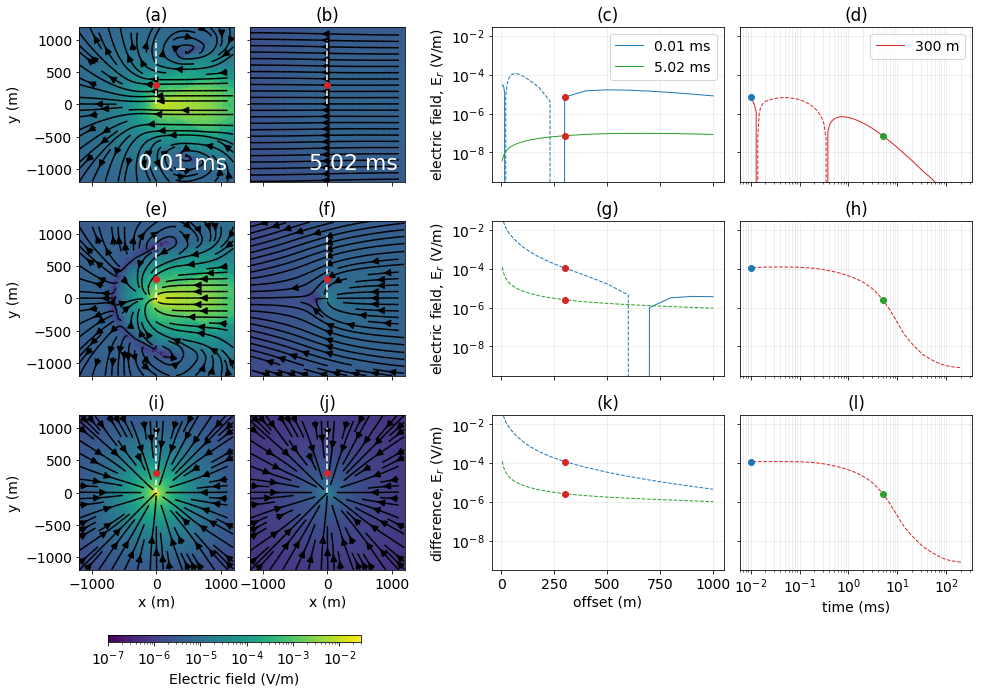

In [62]:
fig, ax = plot_data_overview(
    "background", "casing", "e", times=[1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], include_percent=False
)
fig.savefig("../figures/surface_e_fields_overview", dpi=250,  bbox_inches="tight")



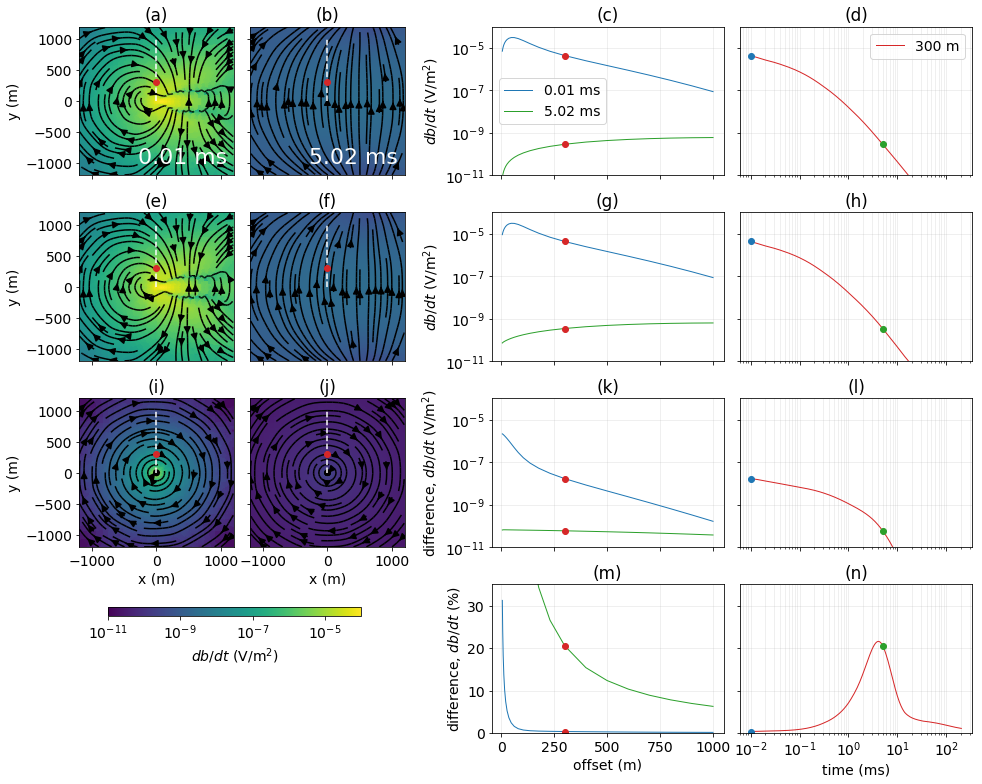

In [63]:
fig, ax = plot_data_overview(
    "background", "casing", "dbdt", times=[1e-5, 5e-3],
    d_ylim=np.r_[1e-11, 1e-4], clim=np.r_[1e-11, 1e-4], percent_lim = np.r_[0, 35], 
    include_percent=True
)

fig.savefig("../figures/surface_dbdt_overview", dpi=250,  bbox_inches="tight")



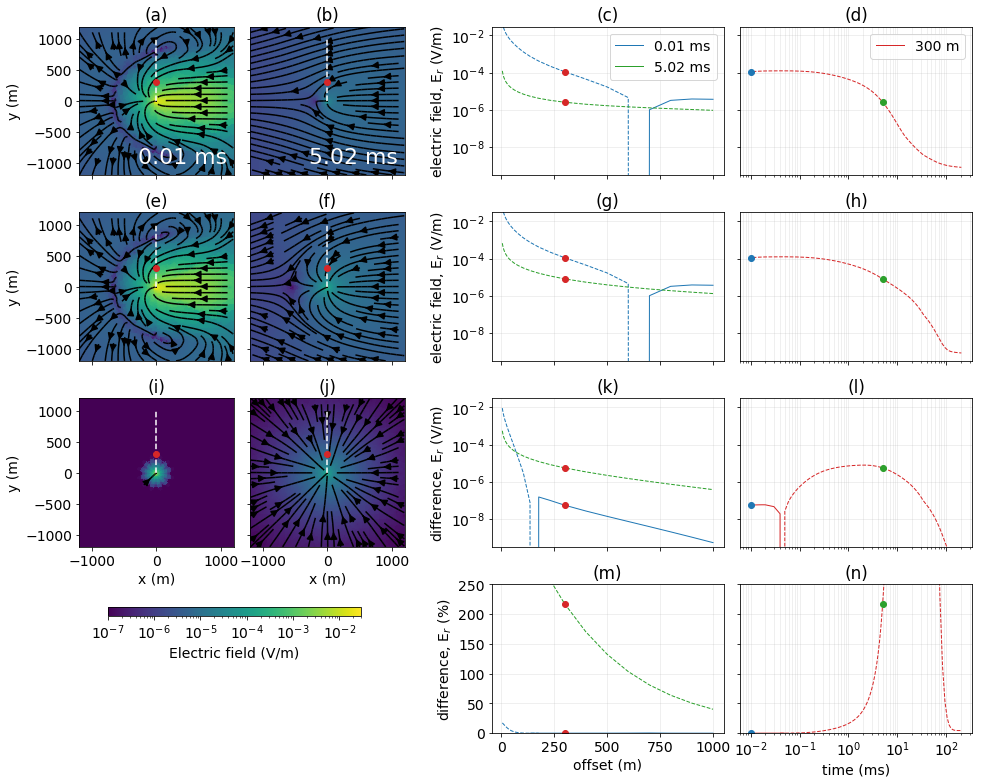

In [64]:
fig, ax = plot_data_overview(
    "casing", "permeable", "e", 
    times = [1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 250],
    include_percent=True
)
fig.savefig("../figures/surface_e_fields_permeable", dpi=250,  bbox_inches="tight")



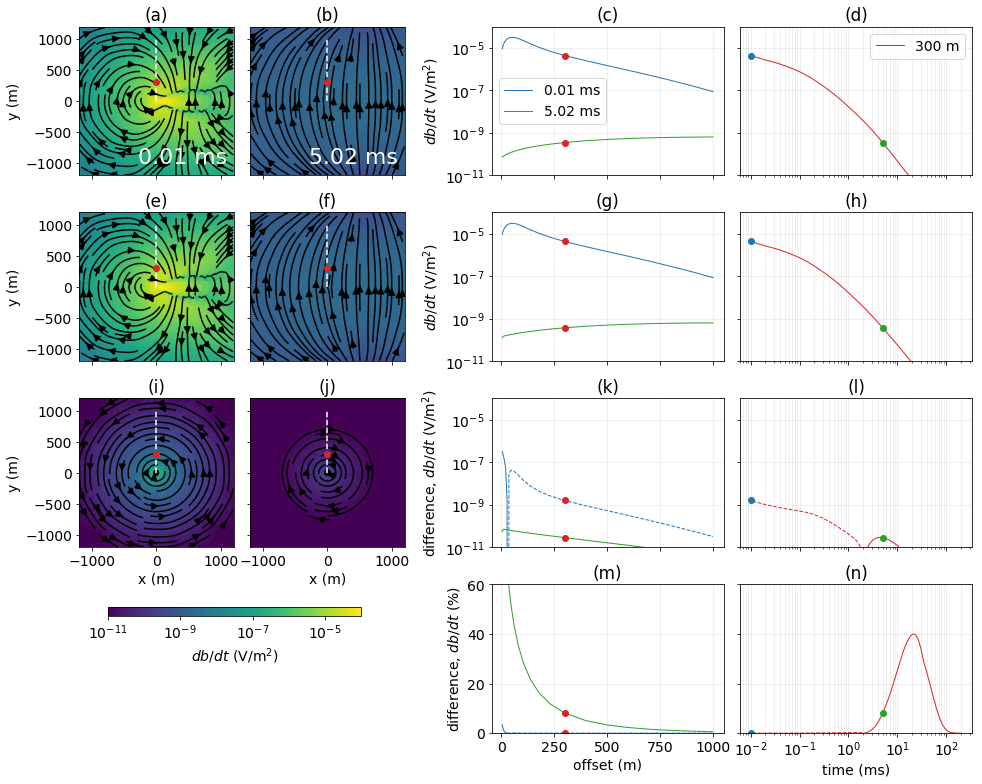

In [66]:
fig, ax = plot_data_overview(
    "casing", "permeable", "dbdt", times=[1e-5, 5e-3],
    d_ylim=np.r_[1e-11, 1e-4], clim=np.r_[1e-11, 1e-4], percent_lim = np.r_[0, 60], 
    include_percent=True
)

fig.savefig("../figures/surface_dbdt_permeable", dpi=250,  bbox_inches="tight")



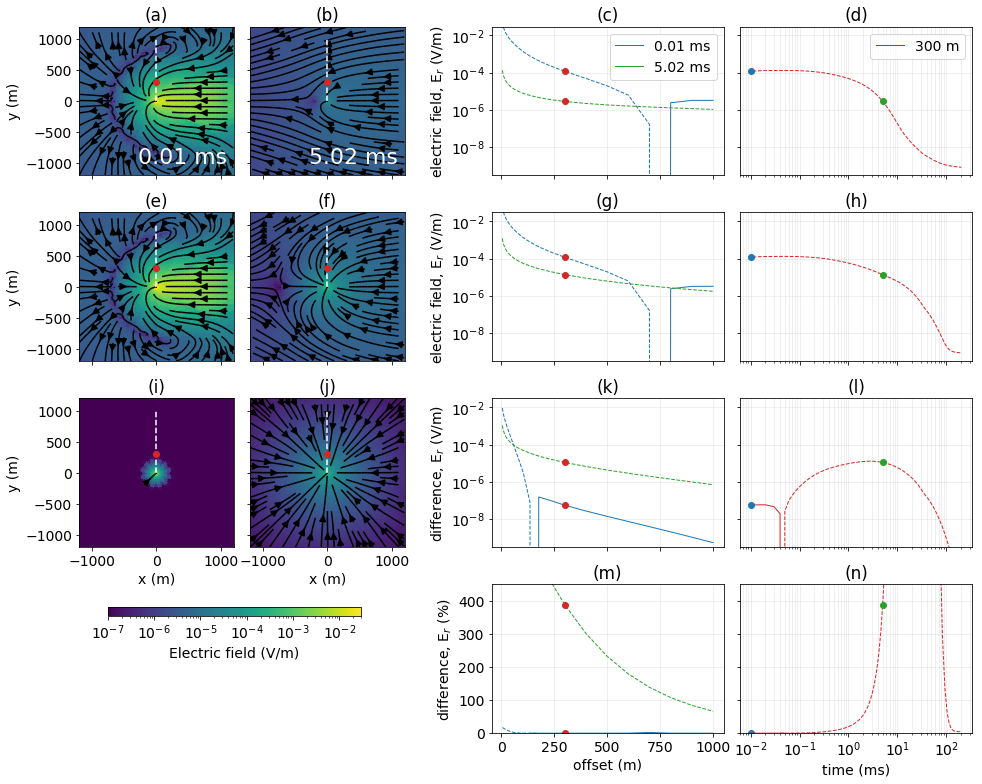

In [67]:
fig, ax = plot_data_overview(
    "casing", "permeable", "e", 
    times = [1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 450],
    include_percent=True, src_ind=1
)
fig.savefig("../figures/surface_e_fields_permeable_downhole", dpi=250,  bbox_inches="tight")



KeyError: 'approx_casing'

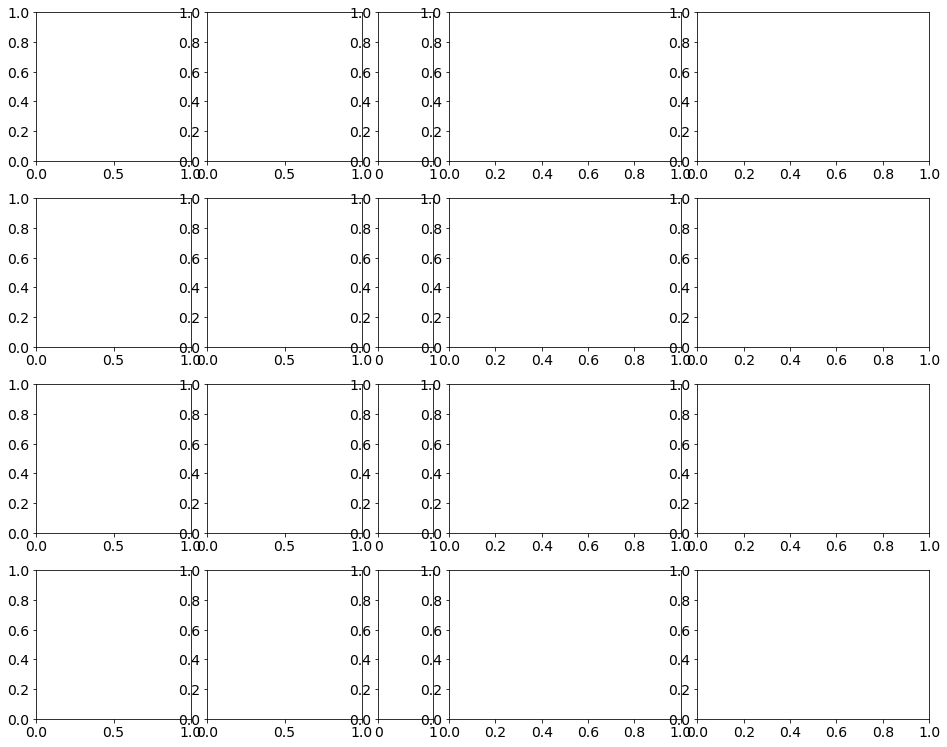

In [68]:
fig, ax = plot_data_overview(
    "casing", "approx_casing", "e", 
    times = [1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 10],
    include_percent=True, src_ind=0
)
fig.savefig("../figures/surface_e_fields_approx_casing", dpi=250, bbox_inches="tight")



In [ ]:
fig, ax = plot_data_overview(
    "permeable", "approx_permeable", "e", 
    times = [1e-5, 5e-3], 
    d_ylim=np.r_[3e-10, 3e-2], clim=np.r_[1e-7, 3e-2], percent_lim=np.r_[0., 25],
    include_percent=True, src_ind=0
)
fig.savefig("../figures/surface_e_fields_approx_permeable", dpi=250, bbox_inches="tight")



In [ ]:
def plot_currents(
    key1="background", key2="casing", times=[1e-5, 1e-3], 
    include_percent=True, 
    d_ylim=None, clim=None,
    percent_lim=np.r_[0., 35], xlim=1200*np.r_[-1, 1], src_ind=0, z_ind=421, x_ind=15
):
    viewerplt = casingSim.FieldsViewer(
        model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key=key1
    )
    
    plt_inds = (t > 1e-5) & (t < 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]
    
    if d_ylim is not None: 
        eps=1e-3*d_ylim[0]
    else:
        eps = 0. 
    
    # data
    if data=="e":
        ddict = data_time
    elif data =="dbdt":
        ddict = dbdt_time
        
    # times
    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

In [ ]:
mod = model.copy()
mod.casing_d = model.casing_b
mod.casing_t = model.casing_b

mod2 = mod.copy()
mod2.casing_l = csz
mod2.casing_top = -500 + csz/2.
mod2.casing_z

In [ ]:

# fig.subplots_adjust(hspace=0.1)
def plot_currents_overview(key1="casing", key2="approx_casing", times=[1e-5, 5e-3], ylim=[3e-7, 1], ylim_percent=[-1, 20]):

    fig, ax = plt.subplots(4, 2, figsize = (12, 12))
    src1 = sim_dict[key1].srcList.srcList[0]
    src2 = sim_dict[key2].srcList.srcList[0]

    demo_time_inds = discretize.utils.closestPoints(fields_dict["casing"].survey.prob.timeMesh, times, 'N')
    demo_times = fields_dict["casing"].survey.prob.timeMesh.gridN[demo_time_inds]

    plt_inds = (t >= 1e-5) & (t <= 5e-1)
    tplt = t[plt_inds]
    tcolor = "C3" 
    tcolors = ["C0", "C2"]


    for ii, time in enumerate(demo_times):
        i = demo_time_inds[ii]
        color=tcolors[ii]

        z_currents, iz1 = casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod)["z"]
        z_currents, iz2 = casingSim.casing_currents(fields_dict[key2][src2, 'j', i], mesh, mod)["z"]

        # currents
        plot_data(-z_currents, -iz1, color=tcolors[ii], ax=ax[0, 0], plot_sign=True, label="{:1.2f} ms".format(time*1e3)) 
        plot_data(-z_currents, -iz2, color=tcolors[ii], ax=ax[1, 0], plot_sign=True) 
        plot_data(-z_currents, -iz1 + iz2, color=tcolors[ii], ax=ax[2, 0], plot_sign=True)
        plot_data(-z_currents, (-iz1 + iz2)/np.absolute(iz1)*100, color=tcolors[ii], ax=ax[3, 0], plot_type="plot", plot_sign=True)

        j = np.where(z_currents == mod2.casing_z.mean())[0]
        ax[0, 0].semilogy(-mod2.casing_z.mean(), -iz1[j], '{}o'.format(tcolor))
        ax[1, 0].semilogy(-mod2.casing_z.mean(), -iz2[j], '{}o'.format(tcolor))
        ax[2, 0].semilogy(-mod2.casing_z.mean(), np.absolute(-iz1[j]+iz2[j]), '{}o'.format(tcolor))
        ax[3, 0].plot(-mod2.casing_z.mean(), np.absolute((-iz1[j] + iz2[j])/np.absolute(iz1[j])*100), '{}o'.format(tcolor))

    # through time
    izt1 = np.hstack([
        casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod2)["z"][1] for i in np.where(plt_inds)[0]
    ])
    izt2 = np.hstack([
        casingSim.casing_currents(fields_dict[key2][src1, 'j', i], mesh, mod2)["z"][1] for i in np.where(plt_inds)[0]
    ])

    plot_data(tplt*1e3, -izt1, color=tcolor, ax=ax[0, 1], plot_sign=True, label="depth: {:1.0f} m".format(-mod2.casing_z.mean()), plot_type="loglog") 
    plot_data(tplt*1e3, -izt2, color=tcolor, ax=ax[1, 1], plot_sign=True, plot_type="loglog") 
    plot_data(tplt*1e3, -izt1 + izt2, color=tcolor, ax=ax[2, 1], plot_sign=True, plot_type="loglog")
    plot_data(tplt*1e3, ((-izt1 + izt2)/np.absolute(izt1)*100), color=tcolor, ax=ax[3, 1], plot_type="semilogx", plot_sign=True)

    for ii, time in enumerate(demo_times):
        i = np.where(tplt == time)[0]
        ax[0, 1].loglog(time*1e3, -izt1[i], "{}o".format(tcolors[ii]))
        ax[1, 1].loglog(time*1e3, -izt2[i], "{}o".format(tcolors[ii]))
        ax[2, 1].loglog(time*1e3, np.absolute(-izt1[i] + izt2[i]), "{}o".format(tcolors[ii]))
        ax[3, 1].semilogx(time*1e3, np.absolute(-izt1[i] + izt2[i])/np.absolute(izt1[i])*100, "{}o".format(tcolors[ii]))

    for i, a in enumerate(ax.T.flatten()):
        a.grid(which="both", alpha=0.4, lw=0.5)
        if i == 3:
            a.set_xlabel('depth (m)')
            a.set_ylim(ylim_percent)
        elif i == 7:
            a.set_xlabel('time (ms)')
            a.set_ylim(ylim_percent)
        else:
            a.set_xticklabels(['']*len(a.get_yticklabels()))
            a.set_xlabel('')
            a.set_ylim(ylim)
    
    ax[0, 0].set_ylabel("current (A)")
    ax[1, 0].set_ylabel("current (A)")
    ax[2, 0].set_ylabel("current difference (A)")
    ax[3, 0].set_ylabel("current difference (%)")

    [a.set_title('({})'.format(ascii_lowercase[i])) for i, a in enumerate(ax.flatten())]

    ax[0, 0].legend()
    ax[0, 1].legend()

    plt.tight_layout()
    
    return fig, ax

In [ ]:
fig, ax =  plot_currents_overview(
    key1="casing", key2="approx_casing", times= [1e-5, 5e-3], ylim=[3e-7, 2], ylim_percent=[-1, 15]
)

fig.savefig("../figures/approx_casing_currents", dpi=250, bbox_inches="tight")

In [ ]:
fig, ax =  plot_currents_overview(
    key1="permeable", key2="approx_permeable", times= [1e-5, 5e-3], ylim=[3e-7, 2], ylim_percent=[-1, 20]
)

fig.savefig("../figures/approx_permeable_currents", dpi=250, bbox_inches="tight")

In [84]:
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

In [85]:
plt_times = [0, 10, 28, 73, 118, 136]
# plt_times = [0, 10, 54, 110, 164, 185, 236]
t[plt_times]

array([0.000e+00, 1.000e-05, 1.000e-04, 1.010e-03, 5.020e-03, 1.002e-02])

In [86]:
len(t)

188

In [87]:
# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

# zlim_casing = np.r_[-1150, 0]
# max_r_casing = 0.075

# x_extent_formation = 1600
# xlim = x_extent_formation*np.r_[-1., 1.]

# x_ticks = [0, -500, -1000, -1500]


# fig = plt.figure(figsize=(28, 5.8*len(plt_times)), dpi=50) 
# # fig.subplots_adjust(bottom=0.8)

# gs = gridspec.GridSpec(len(plt_times), 6, width_ratios=[1, 1, 1, 0.25, 2.5, 2.5]) 
    
# ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*6)]

# for i, tind in enumerate(plt_times):
    
#     ax0 = ax[i*6]
#     ax1 = ax[i*6 + 1]
#     ax2 = ax[i*6 + 2]
#     ax3 = ax[i*6 + 4]
#     ax4 = ax[i*6 + 5]
    
#     ax[i*6 + 3].set_axis_off() # hack to get the spacing I want between the casing and formation plots
    
#     # plot the casing 
#     out_casing = viewer2.plot_cross_section(
#         ax=ax0, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='casing', show_cb=False, casing_outline=True
#     )
#     ax0.set_ylim(zlim_casing)
#     ax0.set_ylabel('z (m)')
    
#     out_casing = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, casing_outline=True
#     )
#     ax0.set_ylim(zlim_casing)
#     ax0.set_ylabel('z (m)')
    
#     out_casing_diff = viewer2.plot_cross_section(
#         ax=ax2, clim=clim_casing, zlim=zlim_casing,
#         xlim=max_r_casing*np.r_[-1., 1.],
#         view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, casing_outline=True, prim_sec="secondary"
#     )
#     ax1.set_ylim(zlim_casing)
#     ax1.set_ylabel('z (m)')
    
#     # currents in the formation
#     out_formation = viewer2.plot_cross_section(
#         ax=ax3, clim=clim_formation, 
#         zlim=np.r_[-x_extent_formation, 0],
#         xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, use_aspect=True,
#         casing_outline=True
#     )
    
#     out_formation2 = viewer2.plot_cross_section(
#         ax=ax4, clim=clim_formation, 
#         zlim=np.r_[-x_extent_formation, 0],
#         xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
#         model_key='permeable', show_cb=False, use_aspect=True,
#         casing_outline=True, prim_sec="secondary"
#     )
    
#     ax4.text(300, -200, "Time: {:.2f} ms".format(t[tind]*1e3), color='w', fontsize=22)

# #     gs.tight_layout(fig)
# #     plt.tight_layout()
#     # zoomed in plot
#     # currents in the formation
    
# #     ax3.set_yticks(z_ticks)
    
#     for a in [ax0, ax1, ax2, ax3, ax4]:
#         a.set_title('')
#         if a not in [ax0, ax1, ax2]: 
#             a.set_aspect(1)
# #         else:
# #             a.set_aspect(1e-4)
            
#         if tind == plt_times[-1]:
#             a.set_xlabel('x (m)')
#             if a in [ax0, ax1, ax2]:
#                 a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         else: 
#             a.set_xticklabels(['']*len(a.get_xticklabels()))
#             a.set_xlabel('')
        
#         if a in [ax1, ax2, ax4]:
#             a.set_ylabel('')
#             a.set_yticklabels(['']*len(a.get_yticklabels()))
    
#         else:
#             a.set_ylabel('z (m)')
        
            
#     if tind == 0:
#         [a.set_title("({})".format(ascii_lowercase[j])) for j, a in enumerate([ax0, ax1, ax2, ax3, ax4])]
        
# # gs.tight_layout(fig)

# # plt.tight_layout()

# cbar_ax = fig.add_axes([0.15, 0.08, 0.24, 0.01])
# cb = plt.colorbar(out_casing[0], cbar_ax, orientation='horizontal')
# cb.set_label('Current density (A/m$^2$)')

# cbar_ax2 = fig.add_axes([0.52, 0.08, 0.35, 0.01])
# cb2 = plt.colorbar(out_formation[0], cbar_ax2, orientation='horizontal')
# cb2.set_label('Current density (A/m$^2$)')
# # cb2.set_ticks([1e-8, 1e2])
# # cb2.update_ticks()

# plt.show()

In [88]:
fig.savefig('../figures/tdem_permeable_currents', bbox_inches='tight', dpi=300)
# fig.savefig('../arxiv-figures/tdem_currents', bbox_inches='tight', dpi=150)

In [89]:
viewer2.primary_key = "casing"

In [90]:
model_names

['casing', 'background', 'permeable', 'approx_casing', 'approx_permeable']

In [91]:
# import matplotlib as mpl
# mpl.rcParams.update(mpl.rcParamsDefault)

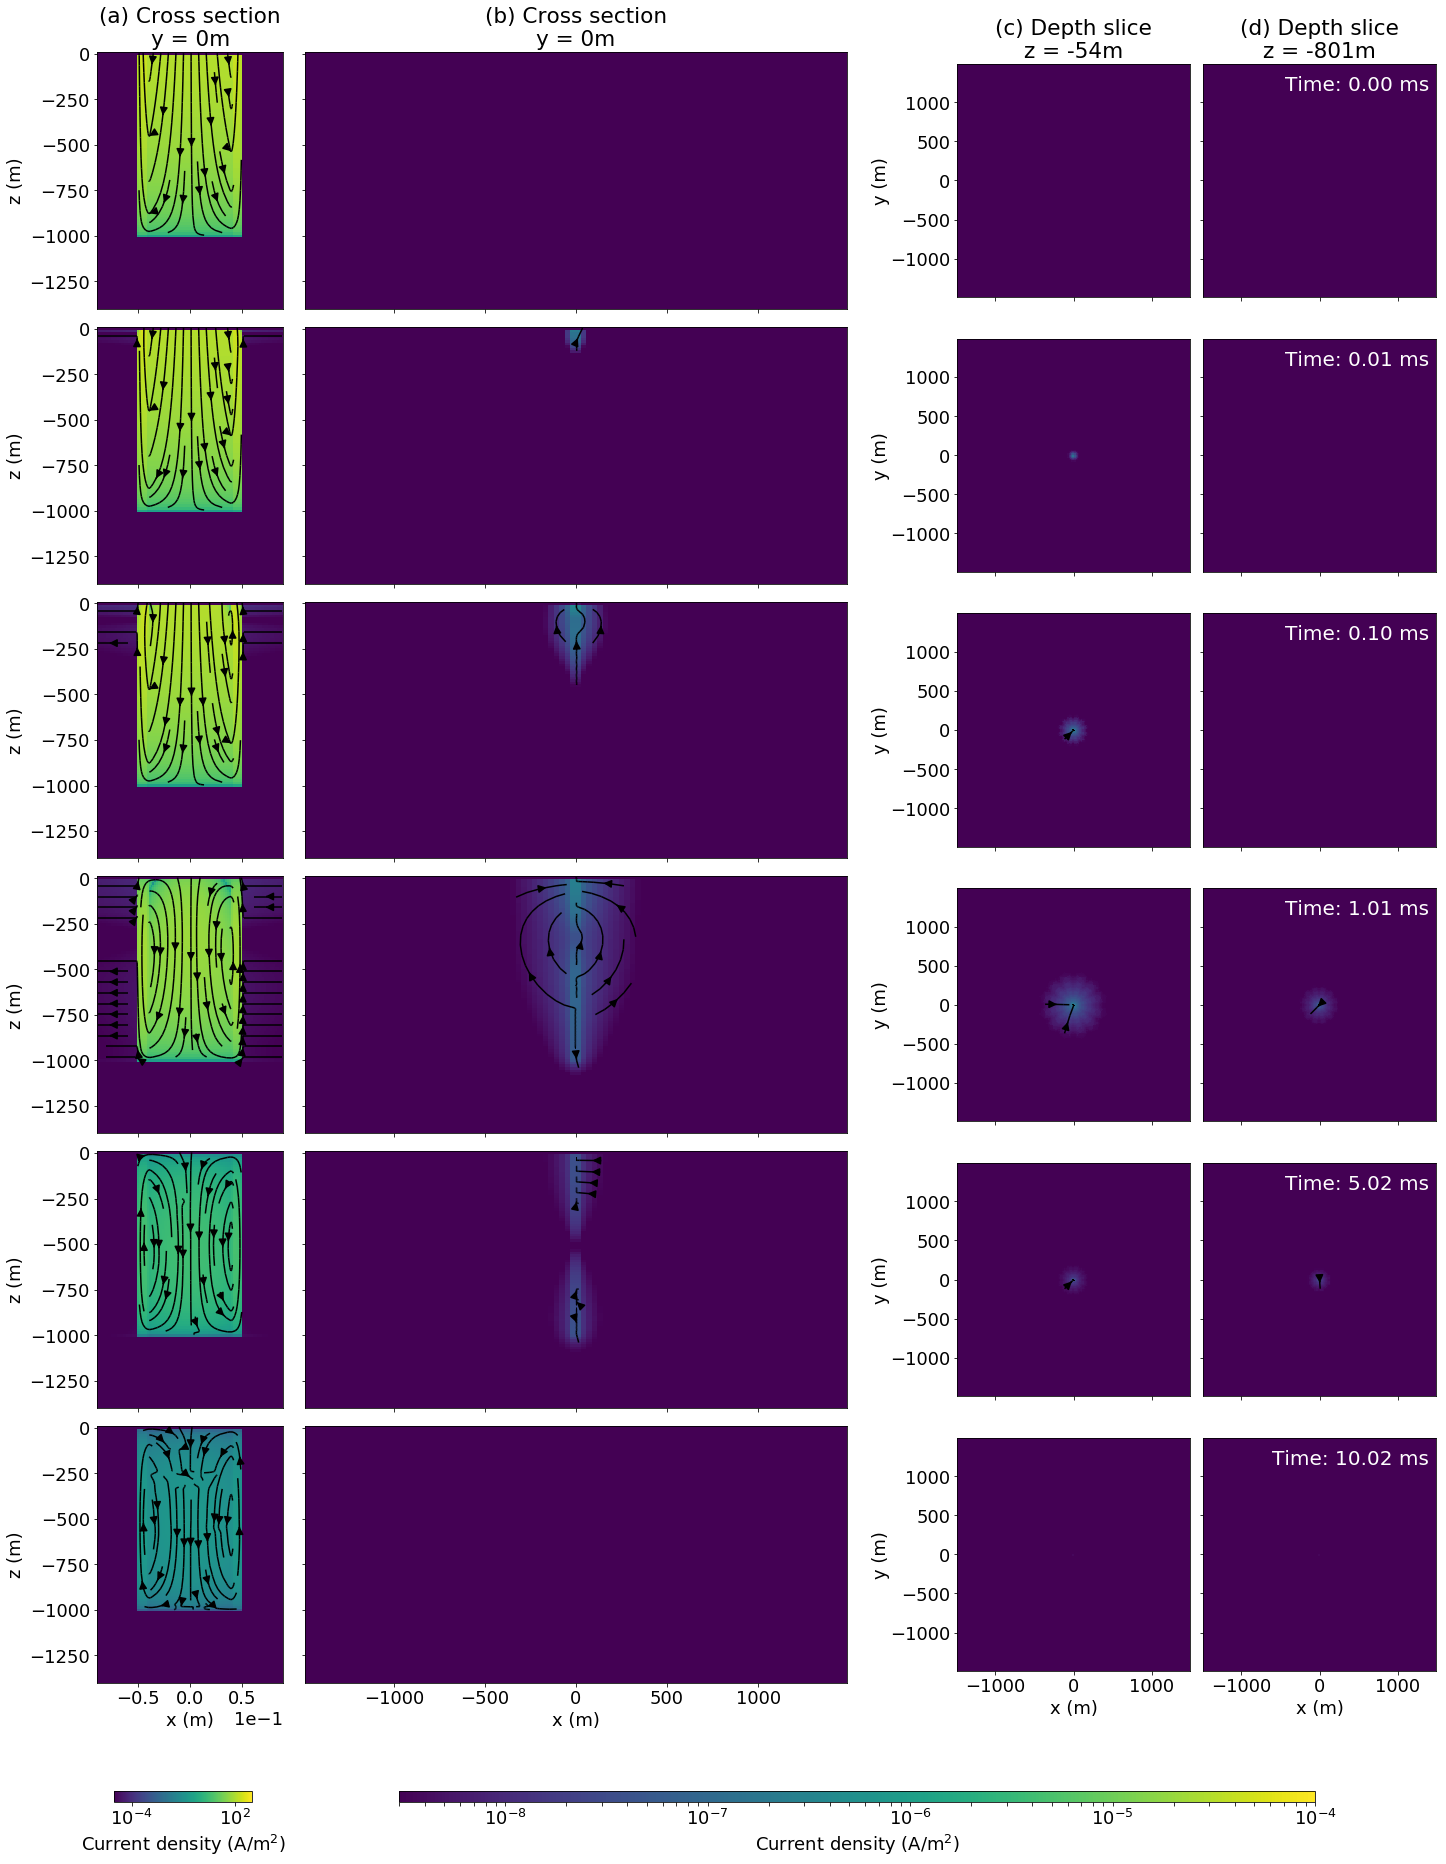

In [92]:
rcParams['font.size'] = 18
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-4 
clim_min = 3e-9
clim = np.r_[clim_min, clim_max]

# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

clim_max_casing = 1e3
clim_min_casing = 1e-5
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.09
top=10.,

xlim = 1490.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

# fig, ax = plt.subplots(4, len(plt_times), figsize )

fig = plt.figure(figsize=(24, 5*len(plt_times))) 
# fig.subplots_adjust(bottom=0.8)

gs = gridspec.GridSpec(len(plt_times), 5, width_ratios=[1.6, 4.8, 0.65, 2, 2], wspace=0.05, hspace=0.07) 
ax = [plt.subplot(gs[i]) for i in range(len(plt_times)*5)]

for i, tind in enumerate(plt_times):
    
    ax0 = ax[i*5 + 1]
    ax1 = ax[i*5 + 3]
    ax2 = ax[i*5 + 4]
    ax3 = ax[i*5]
    
    ax[i*5 + 2].set_axis_off() # hack to get the spacing I want between the casing and formation plots
    
    if model_key == "background":
        ax3.set_axis_off()
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=True,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
        
    
    # plot depth slice above
    for a, z_ind in zip([ax1, ax2], zinds):
        out = viewer2.plot_depth_slice(
            xlim=xlim, ylim=xlim, clim=clim,
            ax=a, z_ind=z_ind, model_key=model_key, view='j',
            show_cb=False, time_ind=tind, rotate=True, theta_shift=mesh.hy[0]/2,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )
    
    ax2.text(1400, 1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")

    
    # zoomed in plot
    # currents in the formation
    
    if not model_key == "background":
        out_casing = viewer2.plot_cross_section(
            ax=ax3, clim=clim_casing, zlim=np.r_[-max_depth, top],
            xlim=max_r_casing*np.r_[-1, 1.],
            view='j', theta_ind=3, time_ind=tind, 
            model_key=model_key, show_cb=False,
            stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
        )
        ax3.set_ylim(np.r_[-max_depth, top])
        ax3.set_ylabel('z (m)')
#     ax3.set_yticks(z_ticks)
    
    for a in [ax0, ax1, ax2, ax3]:
        a.set_title('')
        if a != ax3: 
            a.set_aspect(1)
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
            if a == ax3:
                a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a in [ax2, ax0]:
            if a == ax0 and model_key == "background":
                a.set_ylabel('z (m)')
            else: 
                a.set_ylabel('')
                a.set_yticklabels(['']*len(a.get_yticklabels()))
        
            
        if a == ax1:
            a.set_ylabel('y (m)', labelpad=0.001)
        
            
    if tind == 0:
        if model_key != "background":
            ax0.set_title('(b) Cross section\ny = 0m')
            ax1.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
            ax2.set_title('(d) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]])) 
            ax3.set_title('(a) Cross section\ny = 0m')
        else:
            ax0.set_title('(a) Cross section\ny = 0m')
            ax1.set_title('(b) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[0]]))
            ax2.set_title('(c) Depth slice\nz = {:1.0f}m'.format(sim.prob.mesh.vectorCCz[zinds[1]]))
            ax3.set_title('')
#             ax3.set_title('(a) Cross section\ny = 0m\n')

# gs.tight_layout(fig, pad=0.1)
# plt.tight_layout()

cbar_ax = fig.add_axes([0.30, 0.07, 0.53, 0.005])
cb = plt.colorbar(out[0], cbar_ax, orientation='horizontal')
cb.set_label('Current density (A/m$^2$)')

if model_key != "background":
    cbar_ax2 = fig.add_axes([0.135, 0.07, 0.08, 0.005])
    cb2 = plt.colorbar(out_casing[0], cbar_ax2, orientation='horizontal')
    cb2.set_label('Current density (A/m$^2$)')
    cb2.set_ticks([1e1*clim_min_casing, 1e2])
    cb2.update_ticks()

plt.show()

In [93]:
fig.savefig('../figures/tdem-{}-{}-currents-downhole'.format(model_key, prim_sec), bbox_inches="tight", dpi=250)

In [94]:
s = sim_dict["casing"]

In [95]:
mod = model.copy()
mod.casing_d = model.casing_b
mod.casing_t = model.casing_b

print(mod.casing_a, mod.casing_b)
print(model.casing_a, model.casing_b)

0.0 0.05
0.04000000000000001 0.05


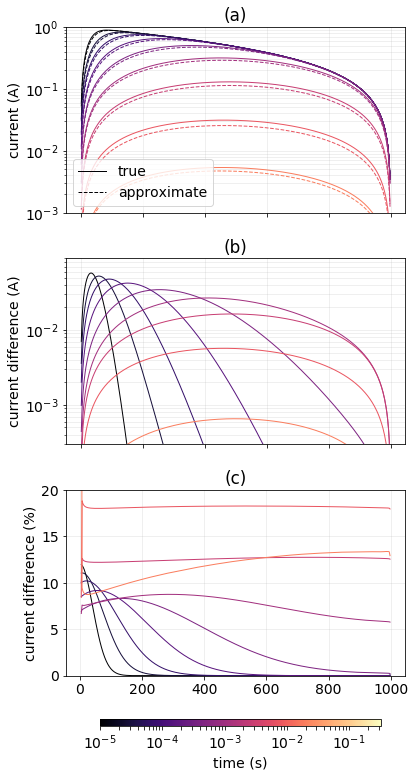

In [96]:
# rcParams['font.size'] = 14
# fig, ax = plt.subplots(3, 1, figsize=(6, 10))


# key1 = "permeable"
# key2 = "approx_{}".format(key1)

# src1 = sim_dict[key1].srcList.srcList[0]
# src2 = sim_dict[key2].srcList.srcList[0]

# for ii, time in enumerate(times):
#     i = time_inds[ii]
#     color=scalar_map.to_rgba(time)

#     z_currents, iz1 = casingSim.casing_currents(fields_dict[key1][src1, 'j', i], mesh, mod)["z"]
#     z_currents, iz2 = casingSim.casing_currents(fields_dict[key2][src2, 'j', i], mesh, mod)["z"]
    
# #     z_charges, charges1 = casingSim.casing_charges(fields_dict[key1][src1, 'charge', i], mesh, mod)
# #     z_charges, charges2 = casingSim.casing_charges(fields_dict[key2][src2, 'charge', i], mesh, mod)
    
#     # currents
#     plot_data(-z_currents, iz1, color, ax[0], ls='-', label="true" if ii ==0 else None) # casing
#     plot_data(-z_currents, iz2, color, ax[0], ls='--', label="approximate" if ii == 0 else None) # casing
    
#     plot_data(-z_currents, iz2 - iz1, color, ax[1], ls='-') # casing
#     plot_data(-z_currents[:-1], (iz2[:-1] - iz1[:-1])/iz1[:-1]*100, color, ax[2], ls='-', plot_type="plot") # casing

# #     # charges
# #     plot_data(-z_charges, charges1, color, ax[0, 1], ls='-', label="true" if ii ==0 else None) # casing
# #     plot_data(-z_charges, charges2, color, ax[0, 1], ls='--', label="approximate" if ii == 0 else None) # casing
    
# #     plot_data(-z_charges, charges2 - charges1, color, ax[1, 1], ls='-') # casing
# #     plot_data(-z_charges[:-1], (charges2[:-1] - charges1[:-1])/charges1[:-1]*100, color, ax[2, 1], ls='-', plot_type="plot") # casing

    
    
# for i, a in enumerate(ax): 
#     a.grid(which="both", alpha=0.4, lw=0.5)
#     a.set_title('({})'.format(ascii_lowercase[i]))
# #     a.set_ylim([3e-9, 9e-2])
    
#     if i < len(ax)-1:
#         a.set_xticklabels(['']*len(a.get_xticklabels()))
        
#     if i == 0: 
#         a.legend()
#         a.set_ylim([1e-3, 1e0])
#         a.set_ylabel('current (A)')
#     elif i == 1:
#         if key1 == "casing":
#             a.set_ylim([3e-5, 9e-3])
#         else:
#             a.set_ylim([3e-4, 9e-2])
#         a.set_ylabel('current difference (A)')
#     else: 
#         if key1 == "casing":
#             a.set_ylim([0, 10])
#         else:
#             a.set_ylim([0, 20])
#         a.set_ylabel('current difference (%)')
        
# ax[0].legend()


# plt.tight_layout()
# cbar_ax = fig.add_axes([0.25, -0.02, 0.65, 0.01])
# cb = plt.colorbar(scalar_map, cbar_ax, orientation="horizontal")
# cb.set_label('time (s)')
#     #     plot_semilogy(x, , color, ax[1], ls='.') # permeable
    
# fig.savefig('../figures/{}_currents'.format(key1), bbox_inches="tight", dpi=200)

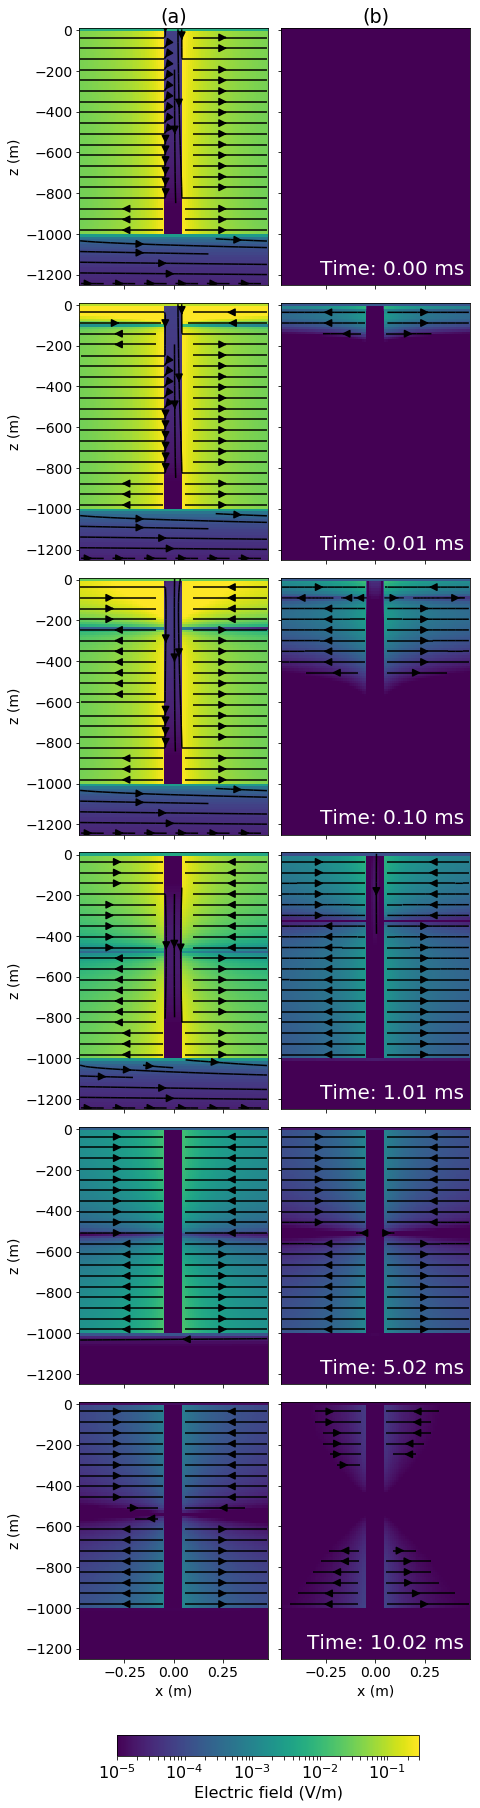

In [97]:
fig, ax = plt.subplots(len(plt_times), 2,  figsize = (7, 5*len(plt_times)))
plt.subplots_adjust(wspace=0.07, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 3e-1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

max_depth = 1250
max_r_casing = 0.48
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i, 0]
    ax1 = ax[i, 1]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax1, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    ax1.text(0.45, -1200, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    
    for a in [ax0, ax1]:
        a.set_title('')
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
#             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax0:
            a.set_ylabel('z (m)')
        else: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))
        
ax[0, 0].set_title("(a)")
ax[0, 1].set_title("(b)")

cbar_ax = fig.add_axes([0.2, 0.08, 0.6, 0.01])
cb = plt.colorbar(out[0], cbar_ax, orientation="horizontal")
cb.set_label('Electric field (V/m)')

#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [98]:
viewer2.primary_key = "permeable"

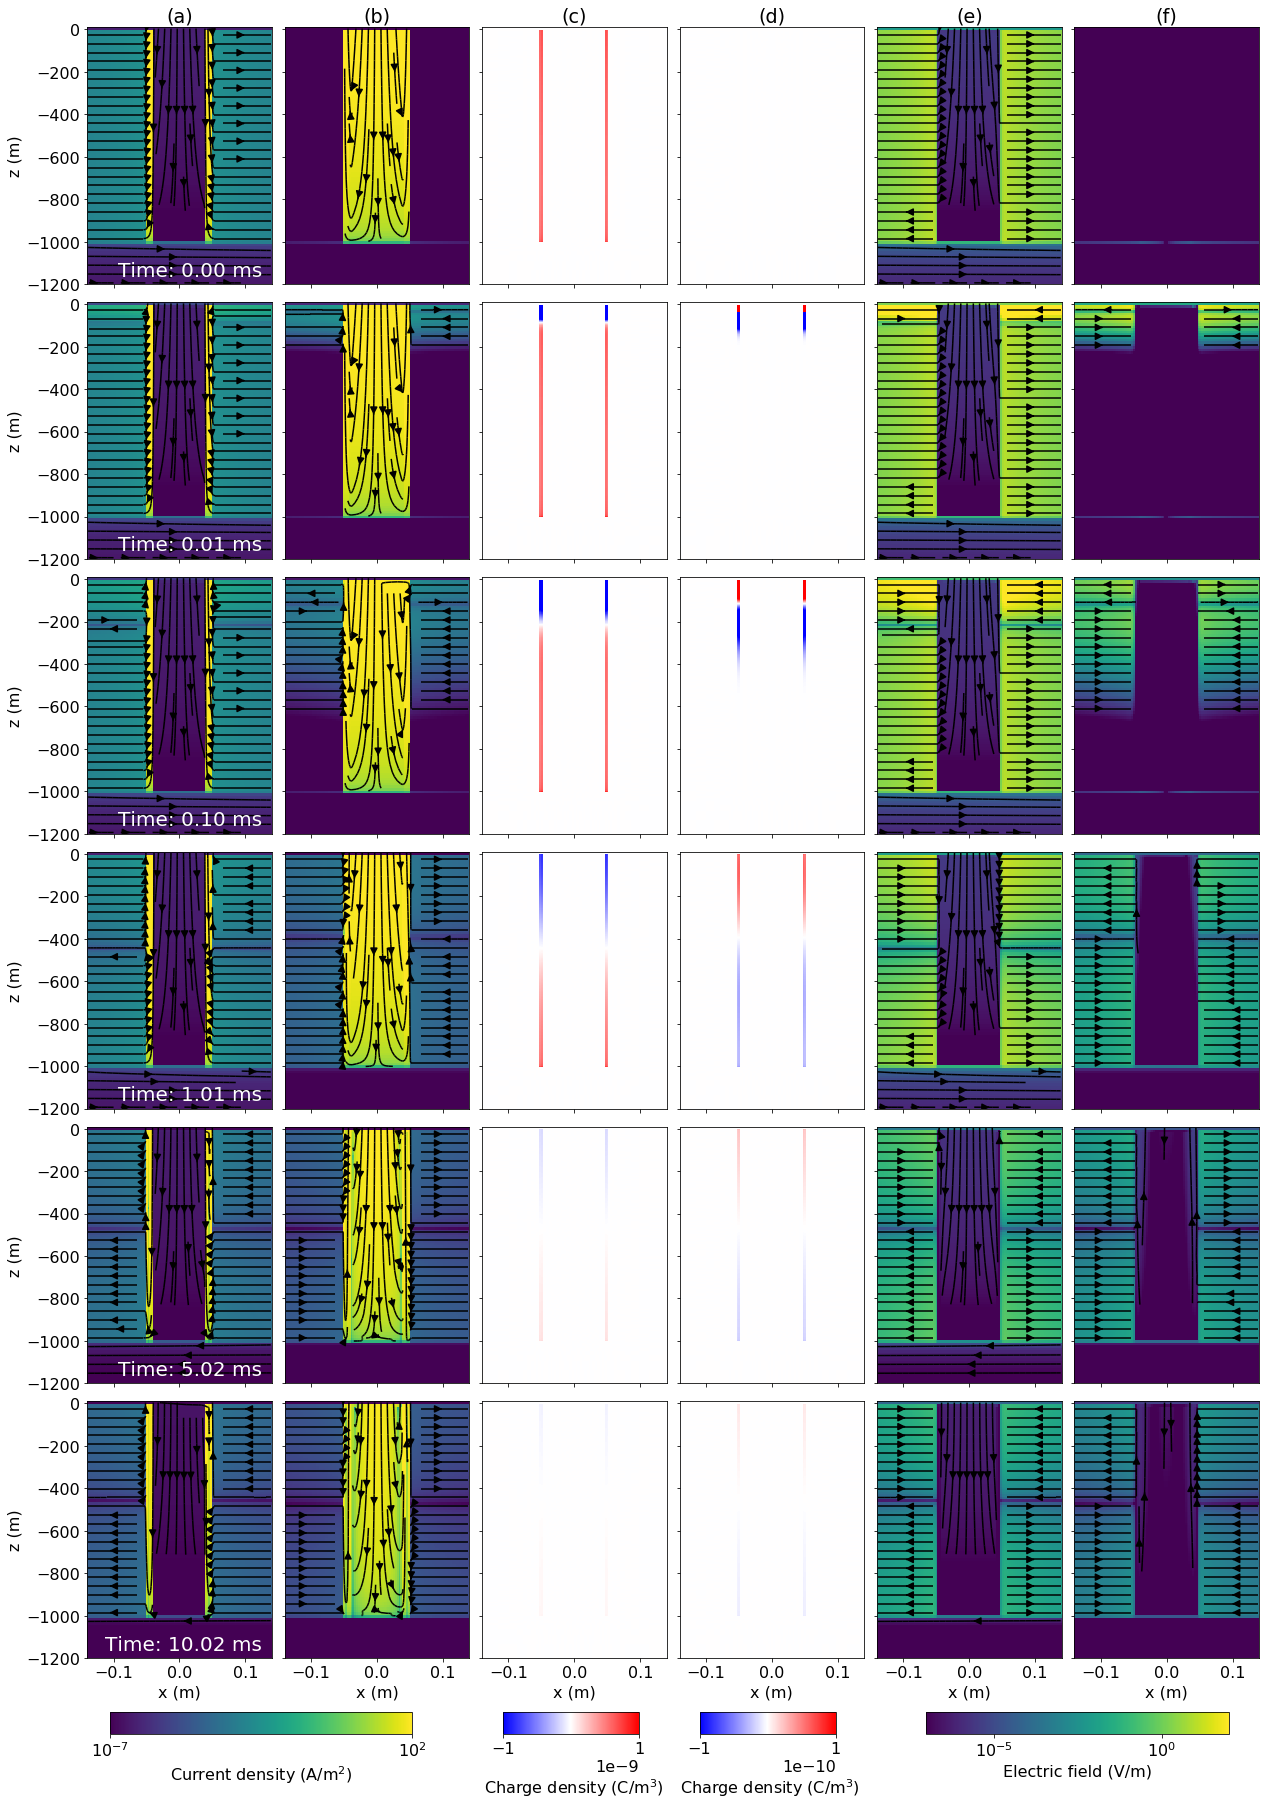

In [99]:
fig, ax = plt.subplots(len(plt_times), 6,  figsize = (3.5*6, 5*len(plt_times)))
plt.subplots_adjust(wspace=0.07, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

clim_charge_total = 1e-9*np.r_[-1, 1]

if viewer2.primary_key == "casing":
    clim_charge = 1e-11*np.r_[-1, 1]
else: 
    clim_charge = 1e-10*np.r_[-1, 1]

clim_current = np.r_[1e-7, 1e2]

max_depth = 1200
max_r_casing = 0.14
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.5, "color":"k"}

model_key = "approx_{}".format(viewer2.primary_key) #.split("_")[-1]
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i, 0]
    ax1 = ax[i, 1]
    ax2 = ax[i, 2]
    ax3 = ax[i, 3]
    ax4 = ax[i, 4]
    ax5 = ax[i, 5]
    
    # currents in the formation
    out_current = viewer2.plot_cross_section(
        ax=ax0, clim=clim_current, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax1, clim=clim_current, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    # currents in the formation
    out_charge_total = viewer2.plot_cross_section(
        ax=ax2, clim=clim_charge_total, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out_charge = viewer2.plot_cross_section(
        ax=ax3, clim=clim_charge, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    # currents in the formation
    out_e = viewer2.plot_cross_section(
        ax=ax4, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec="primary", src_ind=src_ind
    )
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax5, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    ax0.text(max_r_casing - 0.015, -1160, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    
    for a in [ax0, ax1, ax2, ax3, ax4, ax5]:
        a.set_title('')
            
        if tind == plt_times[-1]:
            a.set_xlabel('x (m)')
#             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
        else: 
            a.set_xticklabels(['']*len(a.get_xticklabels()))
            a.set_xlabel('')
        
        if a == ax0:
            a.set_ylabel('z (m)')
        else: 
            a.set_ylabel('')
            a.set_yticklabels(['']*len(a.get_yticklabels()))

for i, a in enumerate(ax[0, :]):
    a.set_title("({})".format(ascii_lowercase[i]))

cbar_ax = fig.add_axes([0.14, 0.09, 0.2, 0.01])
cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
cb.set_label('Current density (A/m$^2$)')
cb.set_ticks(clim_current)

cbar_ax = fig.add_axes([0.4, 0.09, 0.09, 0.01])
cb = plt.colorbar(out_charge_total[0], cbar_ax, orientation="horizontal")
cb.set_label('\n Charge density (C/m$^3$)')
cb.set_ticks(clim_charge_total)

cbar_ax = fig.add_axes([0.53, 0.09, 0.09, 0.01])
cb = plt.colorbar(out_charge[0], cbar_ax, orientation="horizontal")
cb.set_label('\n Charge density (C/m$^3$)')
cb.set_ticks(clim_charge)

cbar_ax = fig.add_axes([0.68, 0.09, 0.2, 0.01])
cb = plt.colorbar(out_current[0], cbar_ax, orientation="horizontal")
cb.set_label('Electric field (V/m)')
cb.set_ticks(clim)
# cb.set_ticks([1e1*clim_current[0], 1e-1*clim_current[1]])

#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [100]:
fig.savefig("../figures/electric-{}".format(viewer2.primary_key), dpi=250, bbox_inches="tight")

In [101]:
"electric-{}".format(model_key)

'electric-approx_permeable'

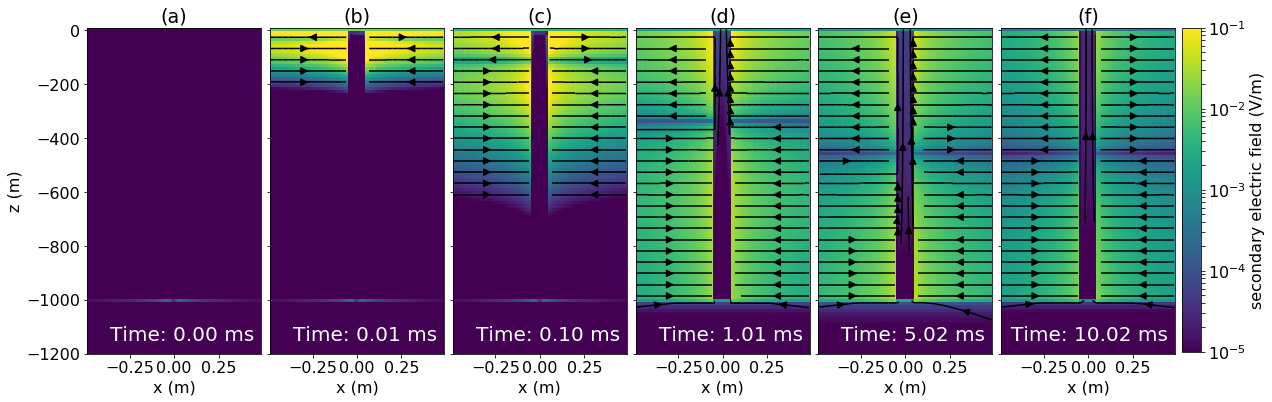

In [102]:
fig, ax = plt.subplots(1, len(plt_times),  figsize = (3.25*len(plt_times), 6))
plt.subplots_adjust(wspace=0.05, hspace=0.07)

rcParams['font.size'] = 16
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-1 
clim_min = 1e-5
clim = np.r_[clim_min, clim_max]

clim_charge = 9e-12*np.r_[-1, 1]

max_depth = 1200
max_r_casing = 0.49
top=10.,

xlim=max_r_casing * np.r_[-1, 1]

x_ticks = [0, -500, -1000, -1500]
# stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

model_key = "approx_casing"
prim_sec = "secondary"

for i, tind in enumerate(plt_times):
    ax0 = ax[i]
#     ax1 = ax[i, 1]
    
    # currents in the formation
    out = viewer2.plot_cross_section(
        ax=ax0, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='e', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=False, # if i < len(plt_times)-1 else True, 
        use_aspect=False,
        stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
    )
    
    ax0.set_title("({})".format(ascii_lowercase[i]))
    ax0.text(0.45, -1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=20, ha="right")
    ax0.set_xlabel("x (m)")
#     ax0.set_aspect(1.5e-3)
    if i > 0:
        ax0.set_ylabel('')
        ax0.set_yticklabels(['']*len(a.get_yticklabels()))
    else:
        ax0.set_ylabel('z (m)')
    
cbar_ax = fig.add_axes([0.905, 0.13, 0.013, 0.75])
cb = plt.colorbar(out[0], cbar_ax)
cb.set_label('secondary electric field (V/m)')
#     # currents in the formation
#     out = viewer2.plot_cross_section(
#         ax=ax1, clim=clim_charge, zlim=np.r_[-max_depth, top],
#         xlim=xlim, view='charge_density', theta_ind=3, time_ind=tind, 
#         model_key=model_key, show_cb=False, use_aspect=False,
#         stream_opts=stream_opts, prim_sec=prim_sec, src_ind=src_ind
#     )
    
#     for a in [ax0, ax1]:
#         a.set_title('')
            
#         if tind == plt_times[-1]:
#             a.set_xlabel('x (m)')
# #             a.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
#         else: 
#             a.set_xticklabels(['']*len(a.get_xticklabels()))
#             a.set_xlabel('')
        
#         if a == ax0:
#             a.set_ylabel('z (m)')
#         else: 
#             a.set_ylabel('')
#             a.set_yticklabels(['']*len(a.get_yticklabels()))
        
            
#         if a == ax1:
#             a.set_ylabel('y (m)', labelpad=0.001)

In [103]:
fig.savefig('../figures/{}-{}-efields'.format(model_key, prim_sec), dpi=250, bbox_inches="tight")

In [71]:
# movies

make_movie = True
viewer2 = casingSim.FieldsViewer(
    model_keys=model_names, sim_dict=sim_dict, fields_dict=fields_dict, primary_key="casing"
)

max_depth = 1.4*casing_l
max_r_casing = 0.09

rcParams['font.size'] = 18
# rcParams['axes.titlepad'] = 0.5

src_ind = 0

clim_max = 1e-4 
clim_min = 3e-9
clim = np.r_[clim_min, clim_max]

# clim_casing = np.r_[1e-5, 1e3]
# clim_formation = np.r_[1e-9, 1e-4]

clim_max_casing = 1e3
clim_min_casing = 1e-5
clim_casing = np.r_[clim_min_casing, clim_max_casing]

max_depth = 1.4*casing_l
max_r_casing = 0.09
top=10.,

xlim = 1490.*np.r_[-1., 1.]

zinds = [400, 101]

x_ticks = [0, -500, -1000, -1500]
stream_opts={"arrowsize":1.6, "color":"k", "density":0.85}

In [105]:
def plot_currents(tind, show_cb, ax, model_key="casing"):
    out = viewer2.plot_cross_section(
        ax=ax, clim=clim, zlim=np.r_[-max_depth, top],
        xlim=xlim, view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=show_cb, use_aspect=True,
        casing_outline=False
    )
    ax.set_title('')
    ax.text(-1400, -100, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    return out

In [106]:
import ipywidgets 
from IPython.display import HTML
from matplotlib import animation, collections

In [109]:
model_key = "casing"

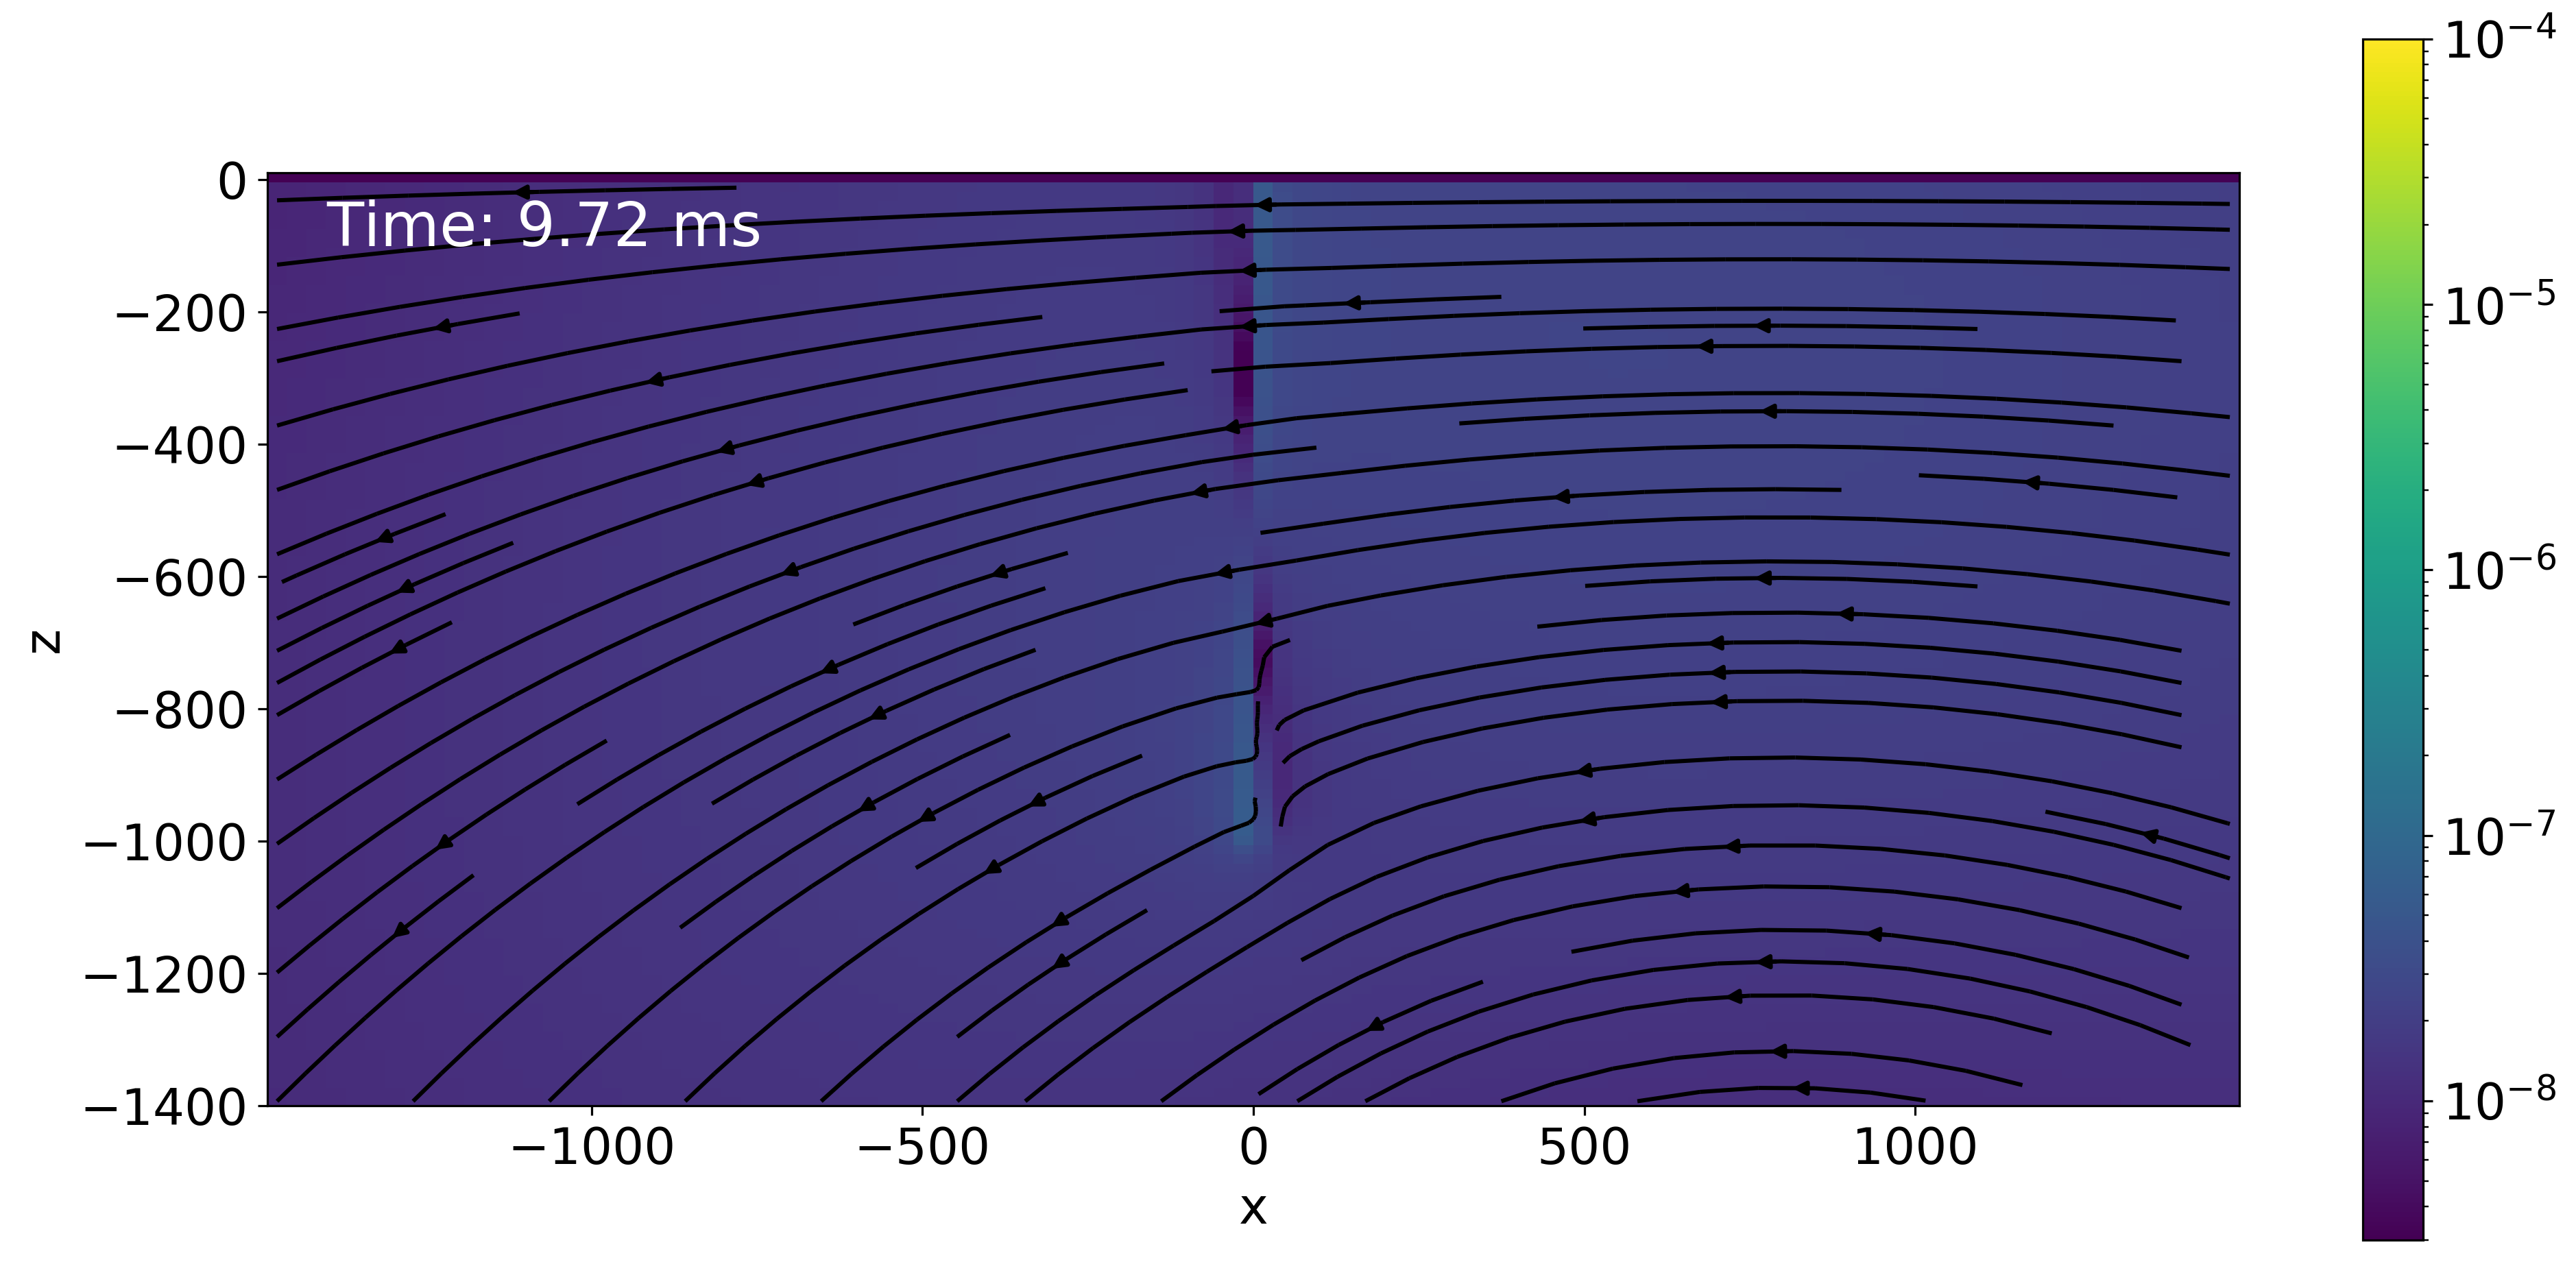

In [110]:
fig, ax = plt.subplots(1, 1, figsize = (16,8), dpi=290)
out = plot_currents(tind=0, ax=ax, show_cb=True, model_key=model_key)

def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    ax.patches = []
    ax.lines = []
    ax.clear()
    return plot_currents(tind=t, show_cb=False, ax=ax, model_key=model_key)

ani = animation.FuncAnimation(fig, update, np.arange(0, 136), init_func=init, blit=False)

 
ani.save(
    "../figures/currents_{}.mp4".format(model_key), writer="ffmpeg", fps=3, dpi=250, bitrate=0, 
    metadata={"title":"TDEM {} currents".format(model_key), "artist":"Lindsey Heagy"}
)

In [126]:
model_key = "permeable"

In [127]:
def plot_currents2(tind, show_cb, ax, model_key="casing"):
    out = viewer2.plot_cross_section(
        ax=ax, clim=clim_casing, zlim=np.r_[-1200, top],
        xlim=max_r_casing*np.r_[-1, 1.], view='j', theta_ind=3, time_ind=tind, 
        model_key=model_key, show_cb=show_cb, use_aspect=False,
        casing_outline=False
    )
    ax.set_title('')
    ax.set_aspect(3e-4)
    ax.text(-0.9*max_r_casing, -1150, "Time: {:.2f} ms".format(sim.prob.times[tind]*1e3), color='w', fontsize=22)
    
    return out


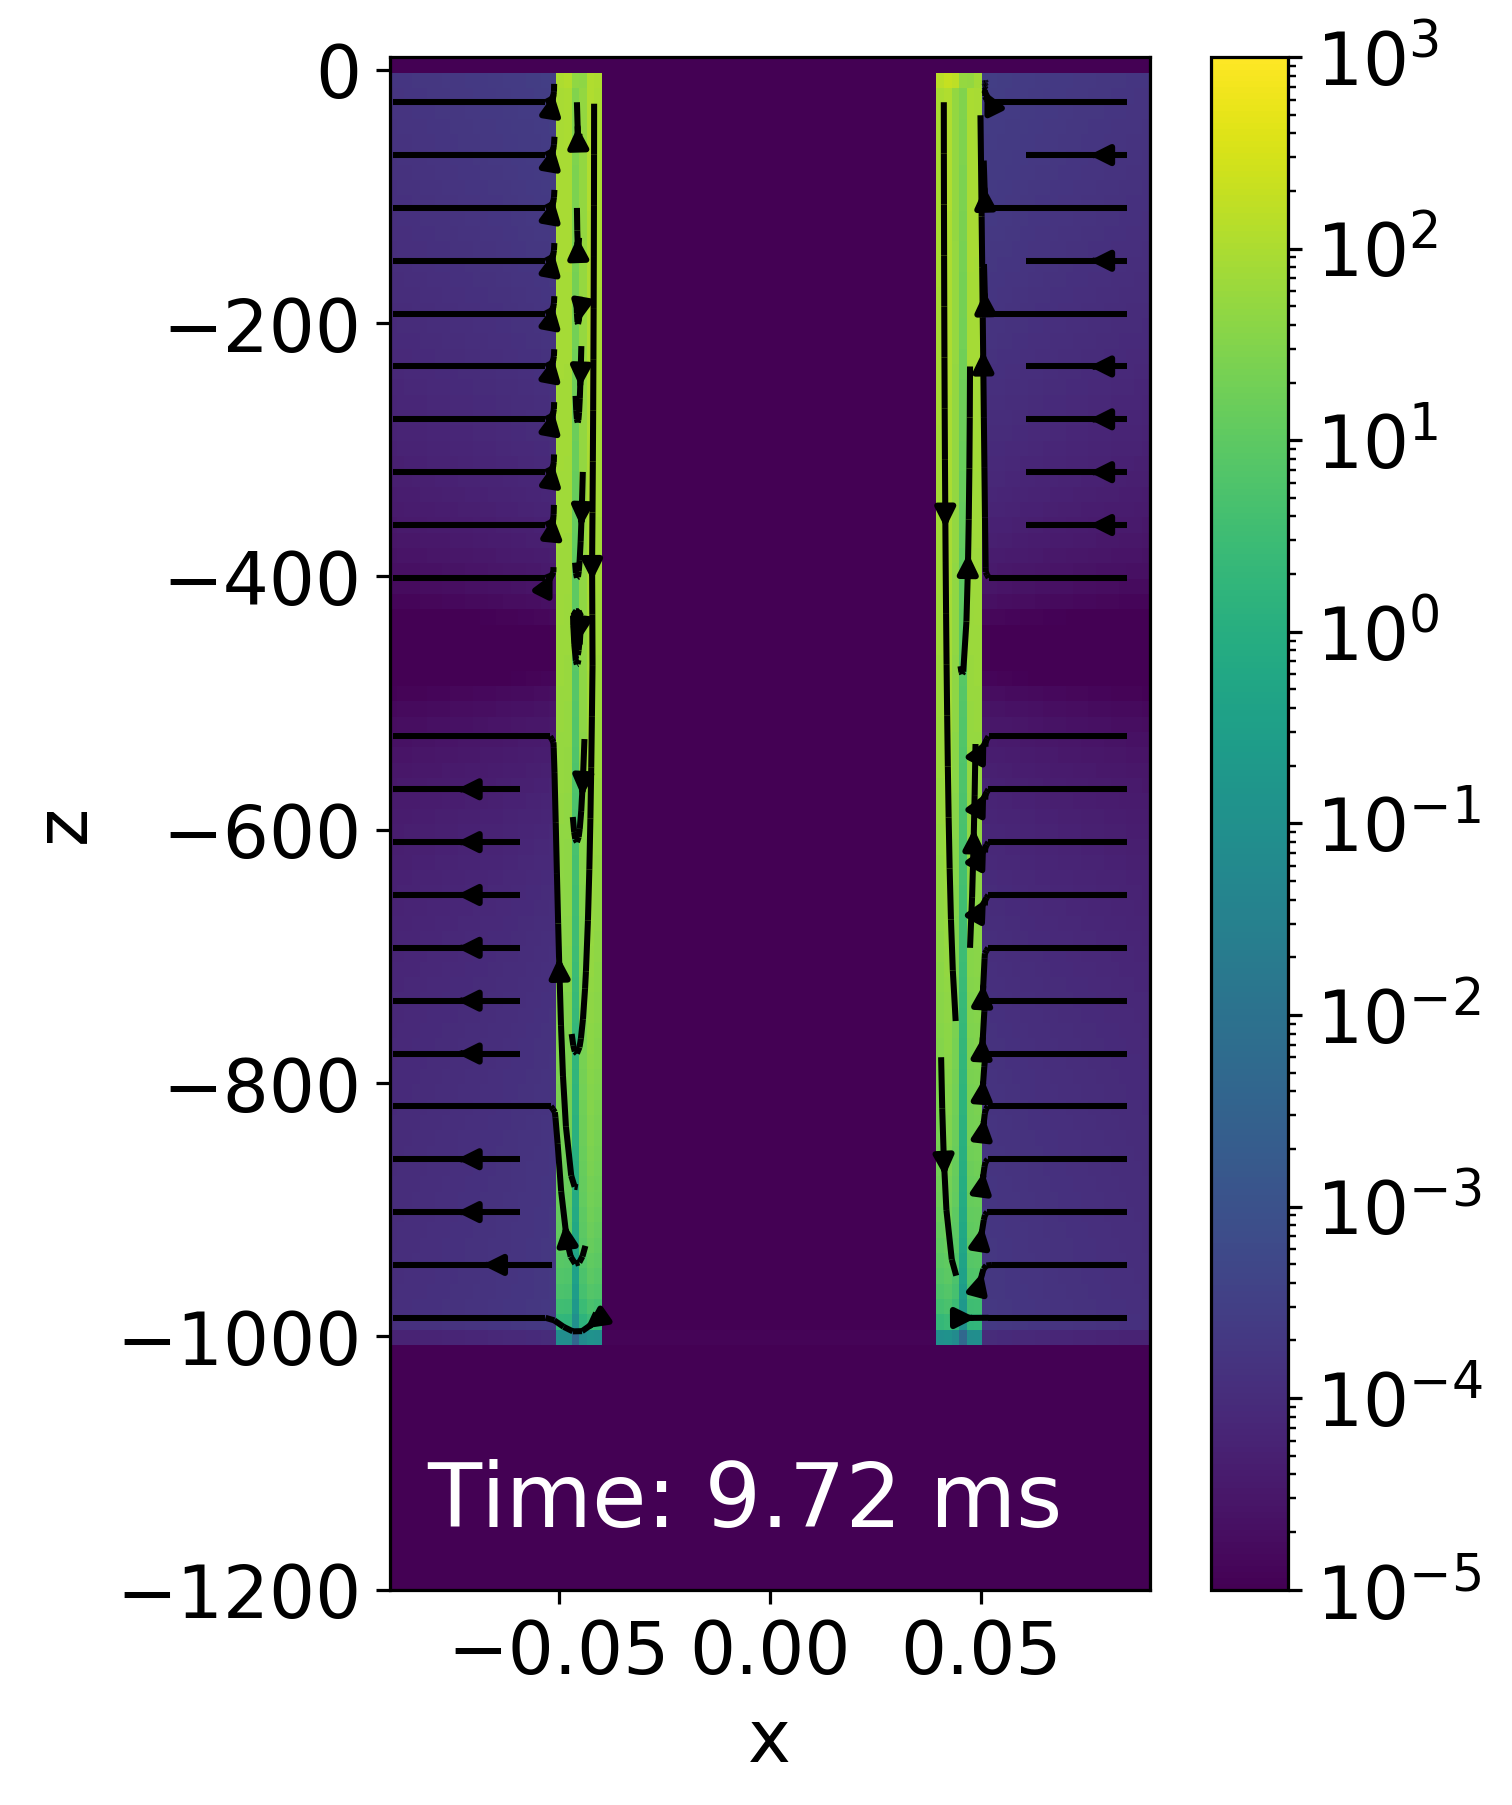

In [128]:
fig, ax = plt.subplots(1, 1, figsize = (5.5, 7), dpi=290)
out = plot_currents2(tind=0, ax=ax, show_cb=True, model_key=model_key)

def init():
    [o.set_array(None) for o in out if isinstance(o, collections.QuadMesh)]
    return out

def update(t):
    ax.patches = []
    ax.lines = []
    ax.clear()
    return plot_currents2(tind=t, show_cb=False, ax=ax, model_key=model_key)

ani = animation.FuncAnimation(fig, update, np.arange(0, 136), init_func=init, blit=False)

 
ani.save(
    "../figures/currents_zoomed_in_{}.mp4".format(model_key), writer="ffmpeg", fps=3, dpi=250, bitrate=0, 
    metadata={"title":"TDEM {} currents".format(model_key), "artist":"Lindsey Heagy"}
)